In [2]:
# %pip install numpy
# %pip install opencv-python
# %pip install matplotlib

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import collections
from scipy.stats import linregress
import math

<h3> Display Image Functions </h3>

In [4]:
def show(img_input, name):
    plt.figure(figsize = (15,15))
    plt.axis("off")
    plt.title(name)
    plt.imshow(img_input)
    plt.show()

def show_multiple(img_input, names):
    plt.figure(figsize = (10*len(names),10))
    n = len(names)
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis("off")
        plt.title(names[i])
        plt.imshow(img_input[i])
    plt.tight_layout()
    plt.show()

def show_gray(img_input, name):
    plt.figure(figsize = (15,15))
    plt.axis("off")
    plt.title(name)
    plt.imshow(img_input, cmap='gray')
    plt.show()

def show_multiple_gray(img_input, names):
    plt.figure(figsize = (10*len(names),10))
    n = len(names)
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis("off")
        plt.title(names[i])
        plt.imshow(img_input[i], cmap='gray')
    plt.tight_layout()
    plt.show()

def show_multiple_mix(img_input, names, gray):
    plt.figure(figsize = (10*len(names),10))
    n = len(names)
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis("off")
        plt.title(names[i])
        if(gray[i]):
            plt.imshow(img_input[i], cmap='gray')
        else:
            plt.imshow(img_input[i])
    plt.tight_layout()
    plt.show()

<h3>Show Original and Grayscale Puzzle Image</h3>

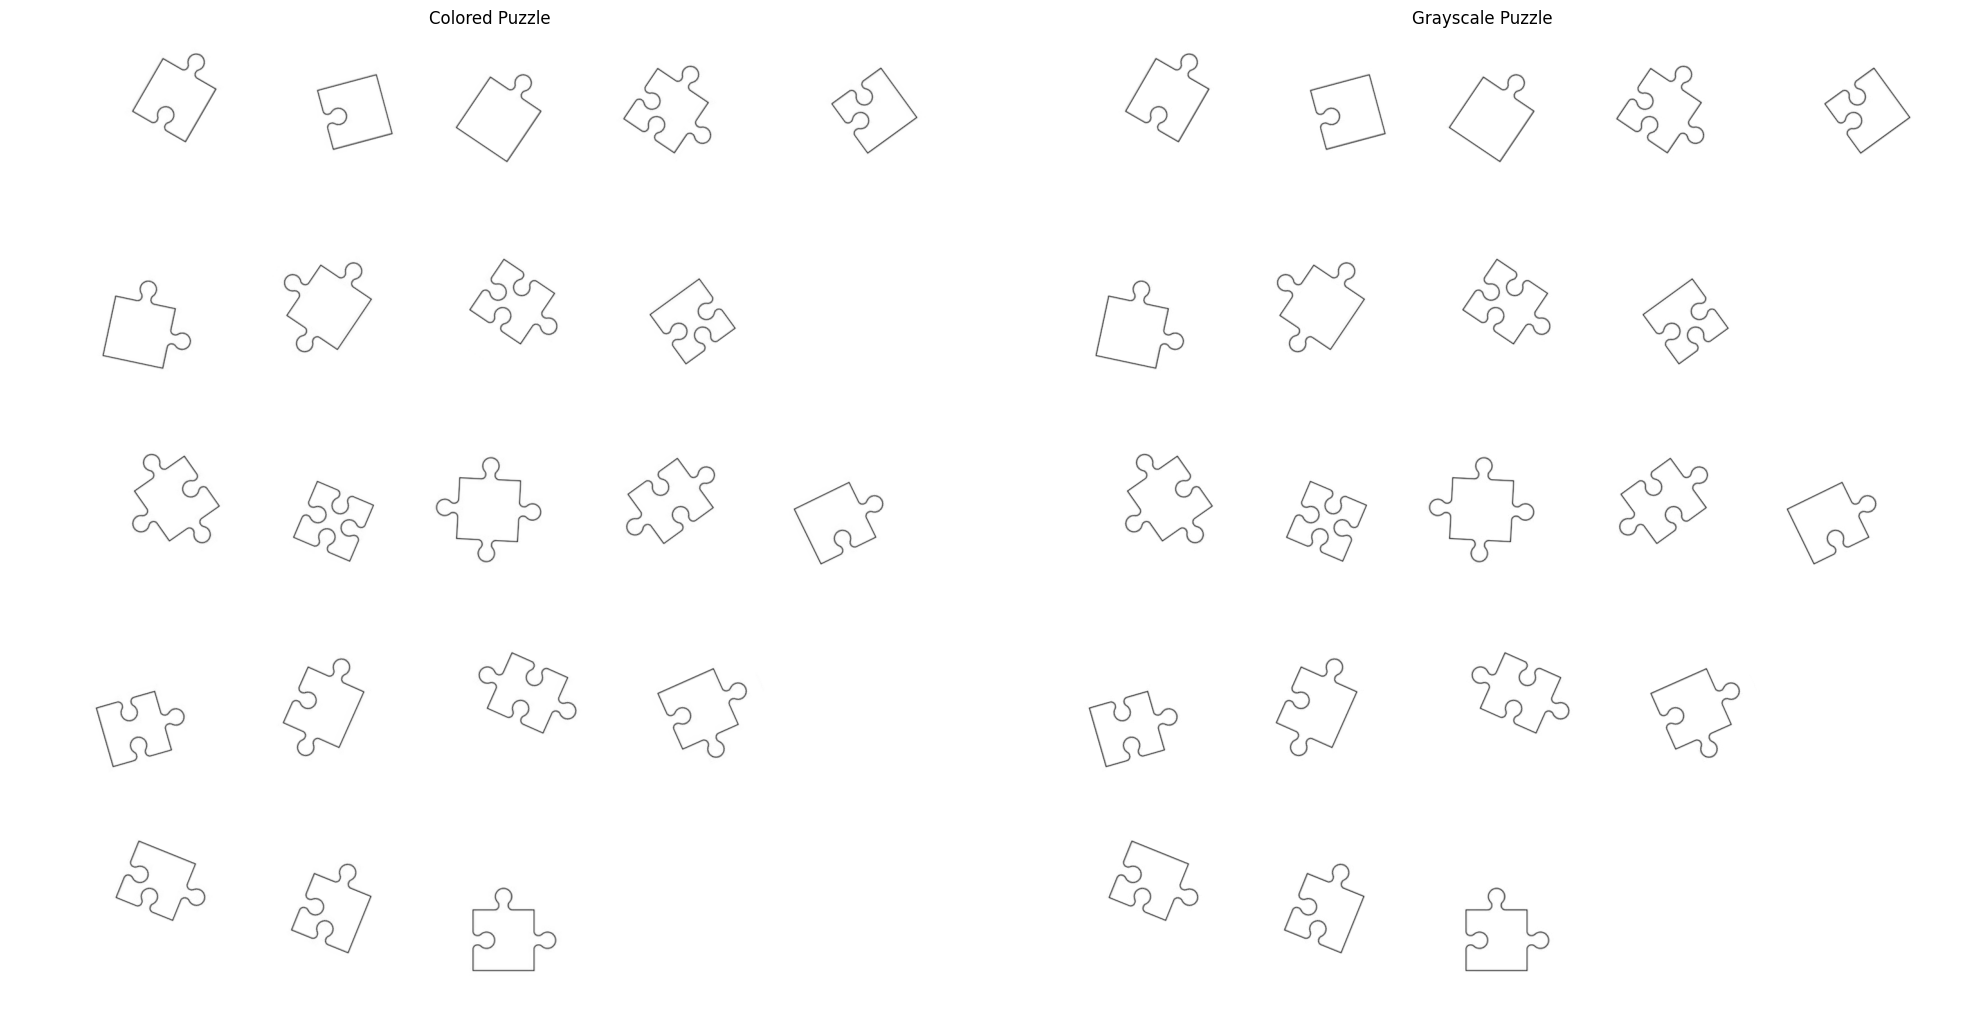

In [5]:

path = 'puzzles/orientation.png'
img_orig = cv2.imread(path, 1)
img_color = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

show_multiple_mix([img_color, gray], ["Colored Puzzle", "Grayscale Puzzle"], [False, True])

<h3>Remove background by removing the most frequent "colors" in RGB domain and changing image to black and white</h3>

In [6]:
#Colored Image
def remove_background(img_input, thresh):
    max = [0, 0, 0]
    std = [0, 0, 0]
    color_img_array = np.array(img_input)
    length, width, _ = color_img_array.shape
    new_image = np.zeros((length, width))

    color = [color_img_array[:,:,0].flatten(), color_img_array[:,:,1].flatten(), color_img_array[:,:,2].flatten()]
    c = ('r','g','b')
    for i, col in enumerate(color):
        histr, _ = np.histogram(col, bins=256, range=[0, 256])
        max[i] = histr.argmax()
        std[i] = np.std(col.flatten(), axis = 0)
    img_input = img_input.astype(int)
    stddev = [int(x*thresh) for x in std]
    for i in range(img_input.shape[0]):
        for j in range(img_input.shape[1]):
            changed = False
            pixel = img_input[i][j]
            if max[0] - stddev[0] < pixel[0] and pixel[0] <  max[0]+stddev[0]:
                if max[1] - stddev[1] < pixel[1] and pixel[1] <  max[1]+stddev[1]:
                    if max[2] - stddev[2] < pixel[2] and pixel[2] <  max[2]+stddev[2]:
                        new_image[i][j] = 0
                        changed = True
            if not changed:
                new_image[i][j] = 255
                
    return new_image
#Grayscale Image
def remove_gray_background(img_input, thresh):
    max = 0
    std = 0
    color = np.array(img_input)
    histr, _ = np.histogram(color, bins=256, range=[0, 256])
    max = histr.argmax()
    img_input = img_input.astype(int)
    stddev = std*thresh
    for i in range(img_input.shape[0]):
        for j in range(img_input.shape[1]):
            changed = False
            if max - stddev < img_input[i][j] and img_input[i][j] <  max+stddev:
                img_input[i][j] = 0
                changed = True
                        
            if not changed:
                img_input[i][j] = 255
    return img_input

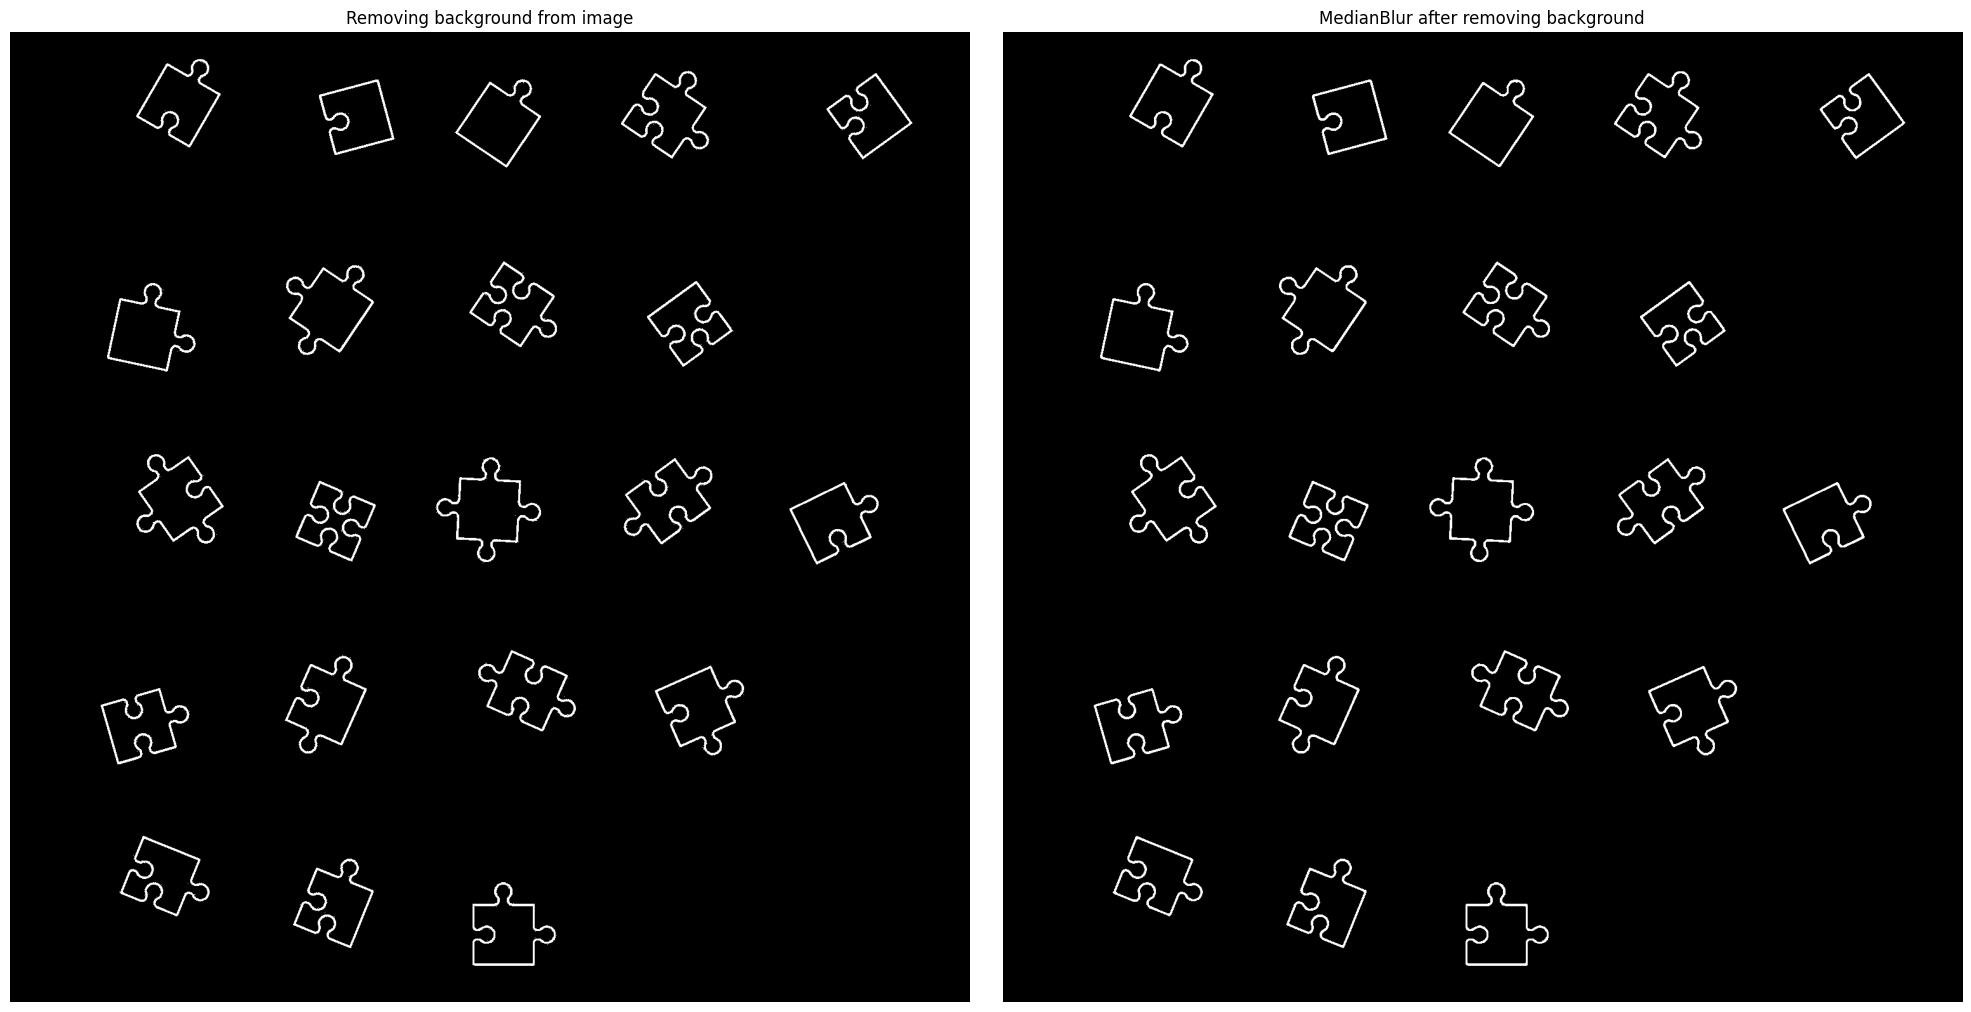

In [7]:
img_bg_removed = np.copy(img_color)
img_bg_removed = remove_background(img_bg_removed, 0.75)
img_bg_removed = np.pad(img_bg_removed, pad_width=10, mode="constant")
img_bg_removed = img_bg_removed.astype(np.uint8)
img_median = cv2.medianBlur(img_bg_removed, 3)
show_multiple_gray([img_bg_removed, img_median], ["Removing background from image", "MedianBlur after removing background"])

<h3>Testing Out Canny Edge Detection</h3>

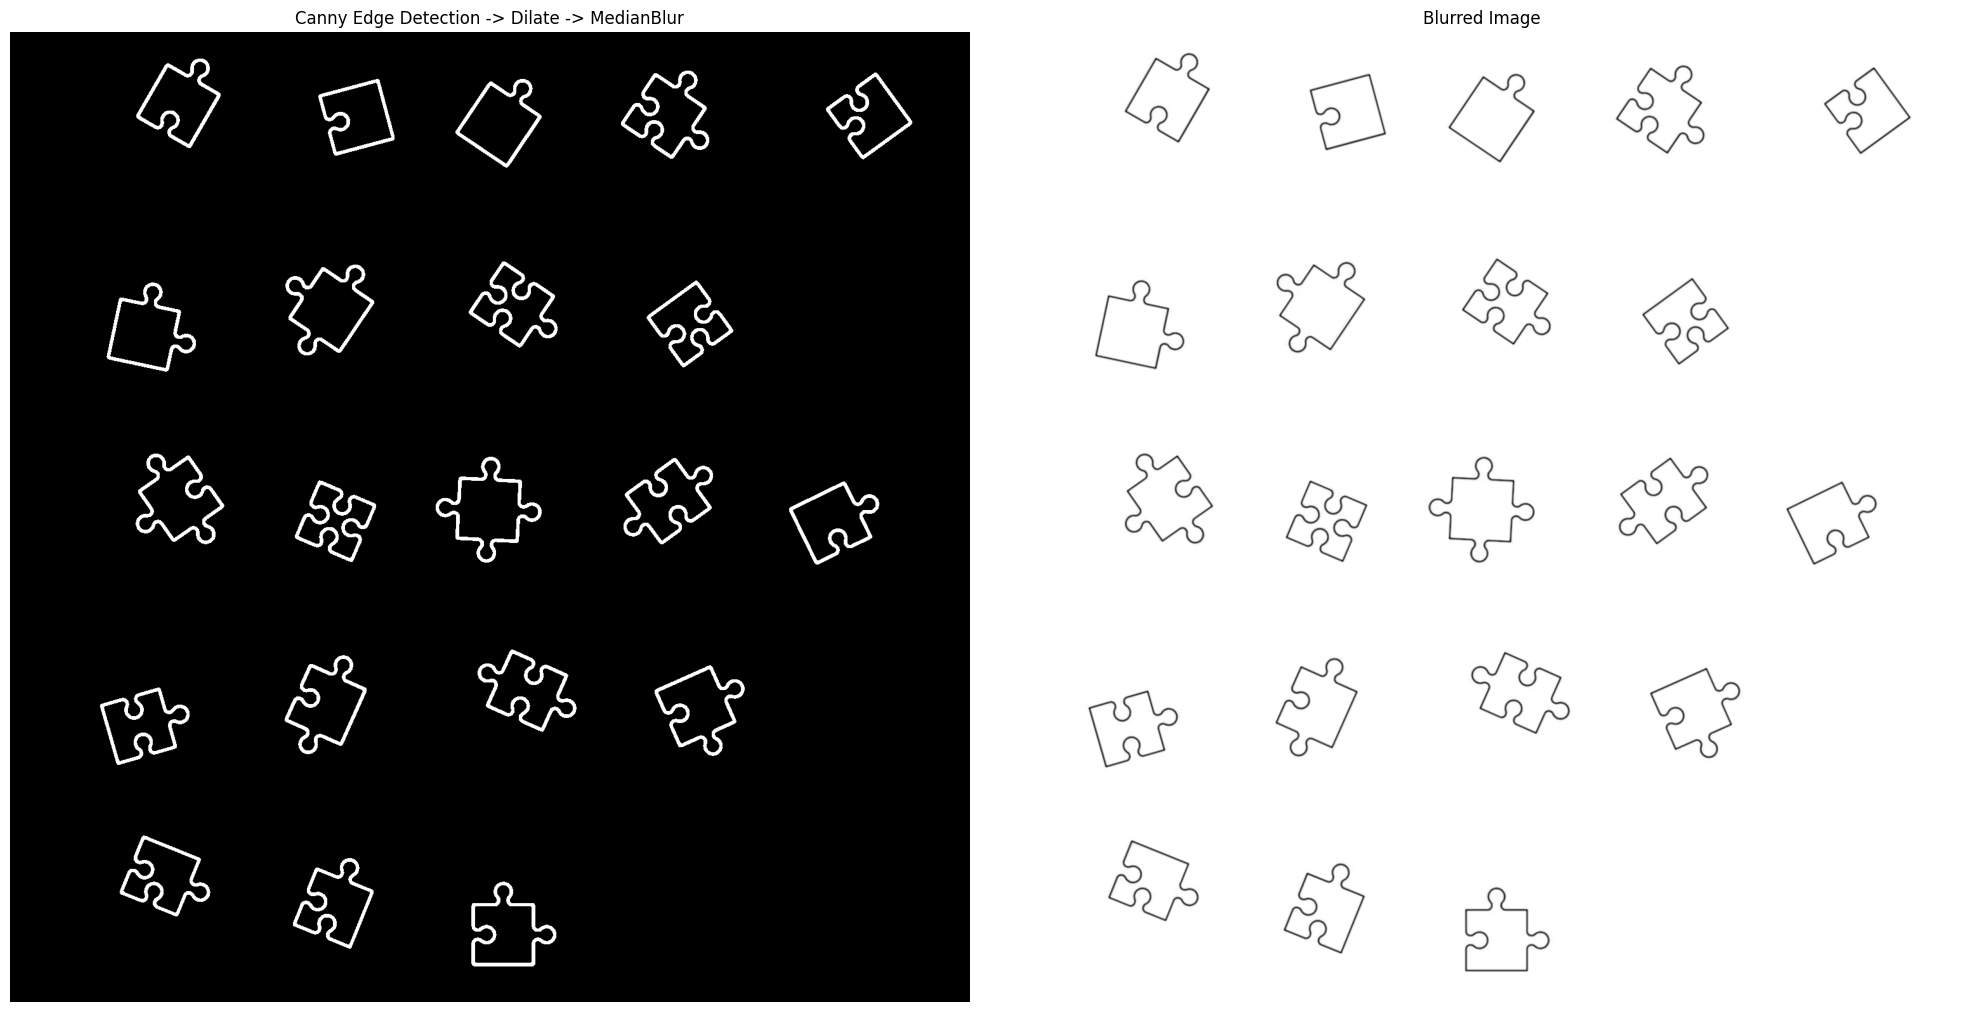

In [8]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
img_blur = cv2.GaussianBlur(gray, (3, 3), 0)
cannyedges = cv2.Canny(image=img_blur, threshold1=70, threshold2=200)
# cannyedges = cannyedges[1:cannyedges.shape[0]-1][1: cannyedges.shape[1]-1]
cannyedges = np.pad(cannyedges, pad_width= 10, mode="constant")
cannyedges = cv2.dilate(cannyedges, kernel)
cannyedges = cv2.medianBlur(cannyedges, 3)
show_multiple_mix([cannyedges, img_blur], ["Canny Edge Detection -> Dilate -> MedianBlur", "Blurred Image"], [True, True])

<h3>Mixing Canny Edge Detection and BG removal</h3>

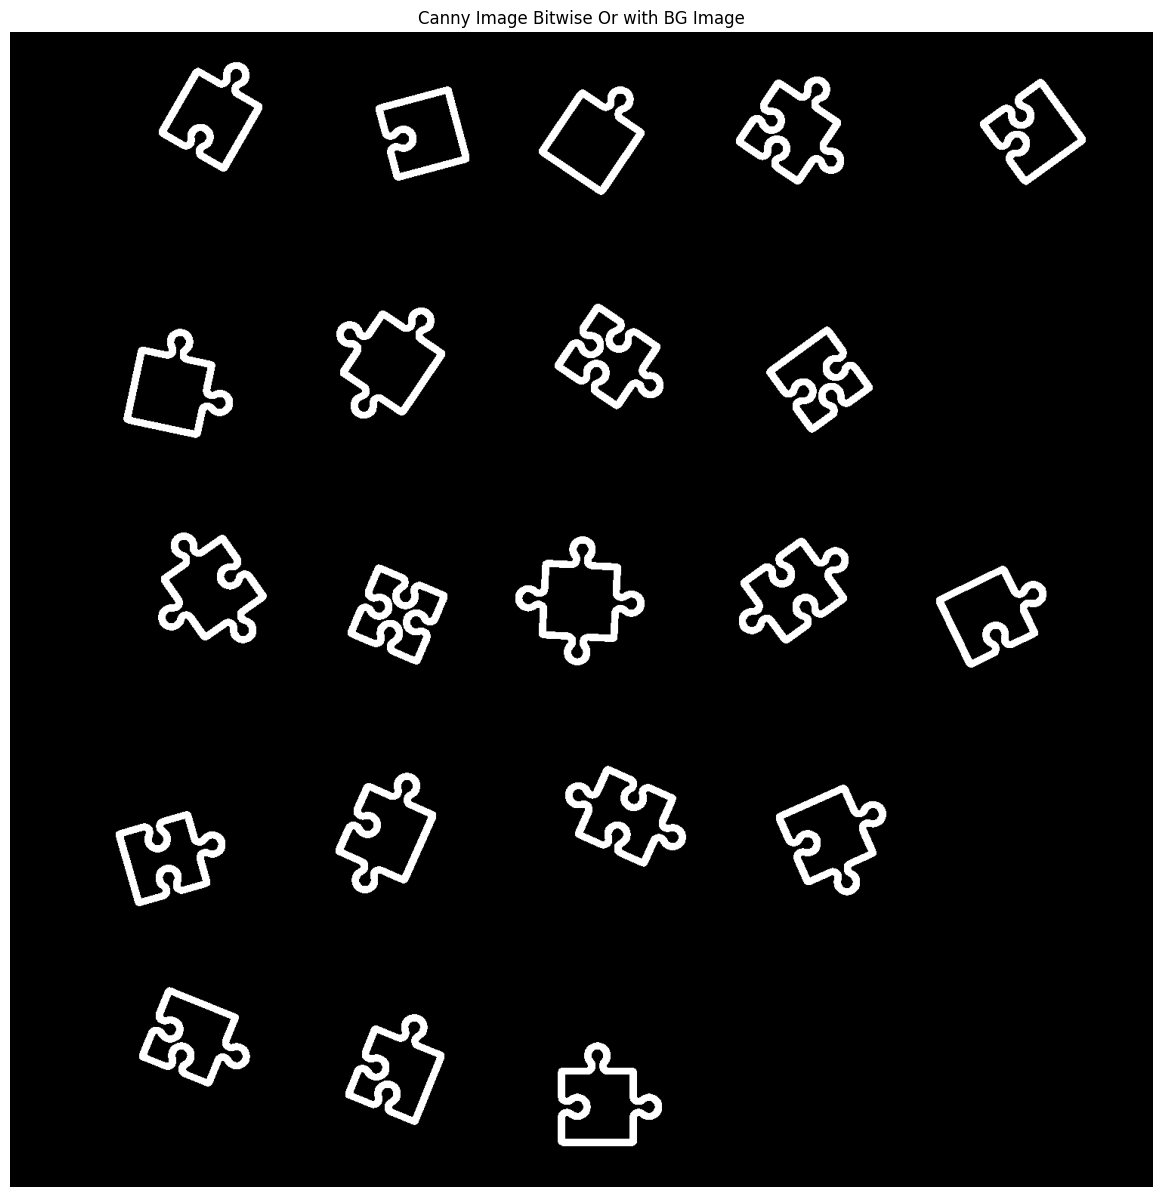

In [9]:
canny_bg_img = np.copy(img_median)
edges = np.copy(cannyedges)
for x in range(canny_bg_img.shape[0]):
    for y in range(canny_bg_img.shape[1]):
        if edges[x][y] != 0:
            canny_bg_img[x][y] = 255
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
canny_bg_img = cv2.dilate(canny_bg_img, kernel)
show_gray(canny_bg_img, "Canny Image Bitwise Or with BG Image")

<h3>Assuming the corner pixel will always contain the background</h3>

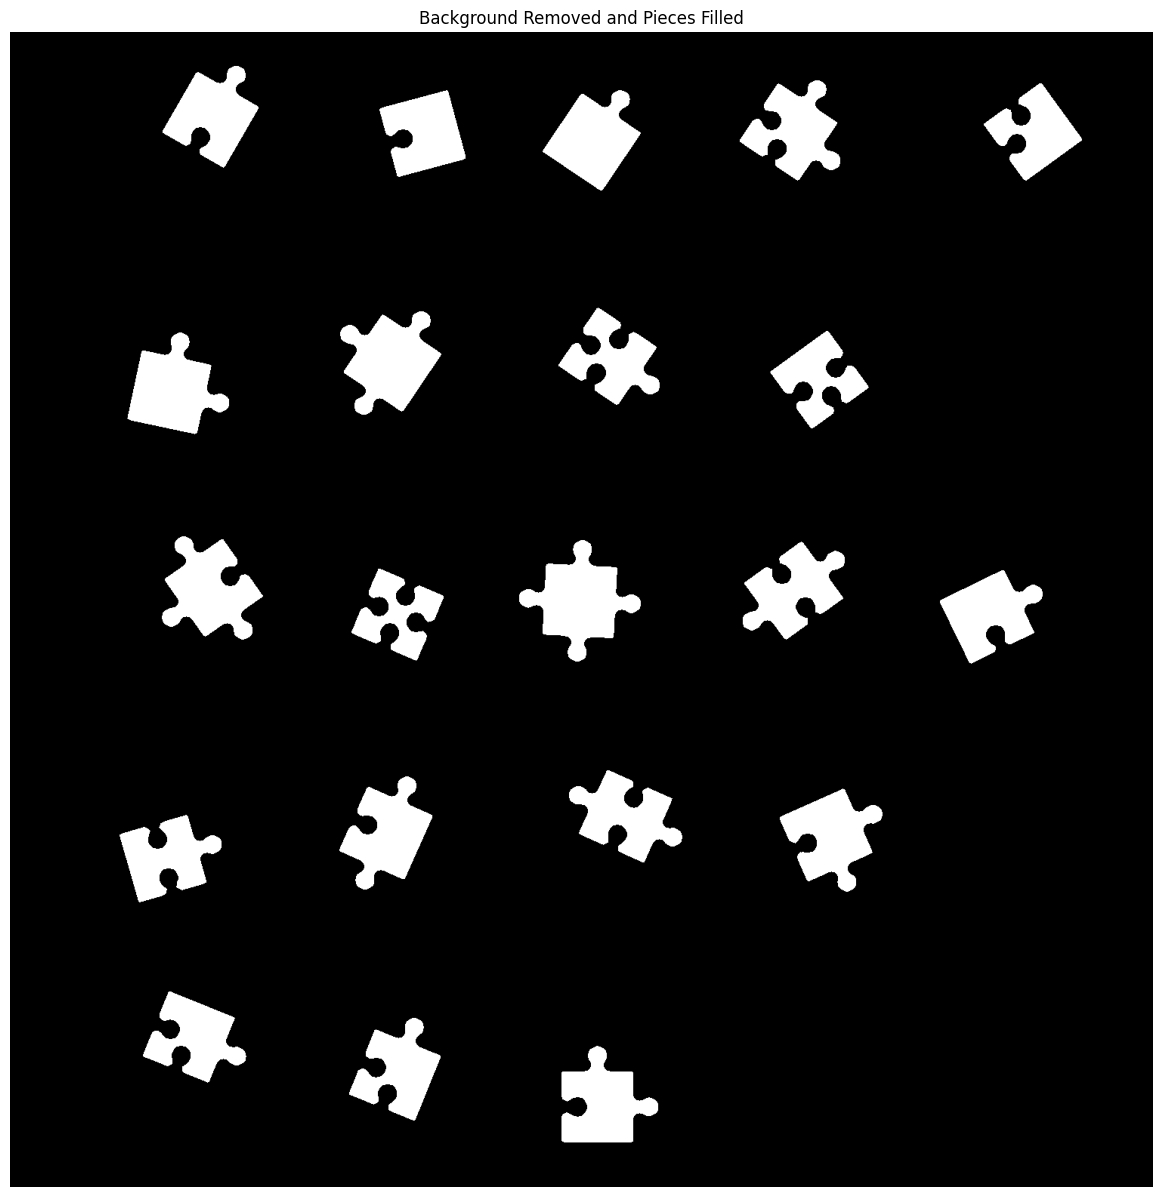

In [10]:
def get_background(is_background, img_compare):
    q = collections.deque([(0, 0)])
    visited = set((0, 0))
    dir = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    l, w = is_background.shape
    while q:
        x, y = q.popleft()
        is_background[x][y] = 1
        for dx, dy in dir:
            if -1 < x + dx and x + dx < l and -1 < y + dy and y + dy < w:
                if (img_compare[x+dx][y+dy] == 0).any():
                    if (x + dx, y + dy) not in visited:
                        q.append((x + dx, y + dy))
                        visited.add((x + dx, y + dy))
    return is_background

def fill_img(background, image):
    for x in range(background.shape[0]):
            for y in range(background.shape[1]):
                if not background[x][y]:
                    image[x][y] = 255
    return image

#get background of canny image + bg image
is_bg = get_background(np.zeros_like(np.array(cannyedges)), canny_bg_img)
filled_pieces = fill_img(is_bg, canny_bg_img)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
filled_pieces = cv2.dilate(filled_pieces, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17,17))
filled_pieces = cv2.erode(filled_pieces, kernel)
show_gray(filled_pieces, "Background Removed and Pieces Filled")


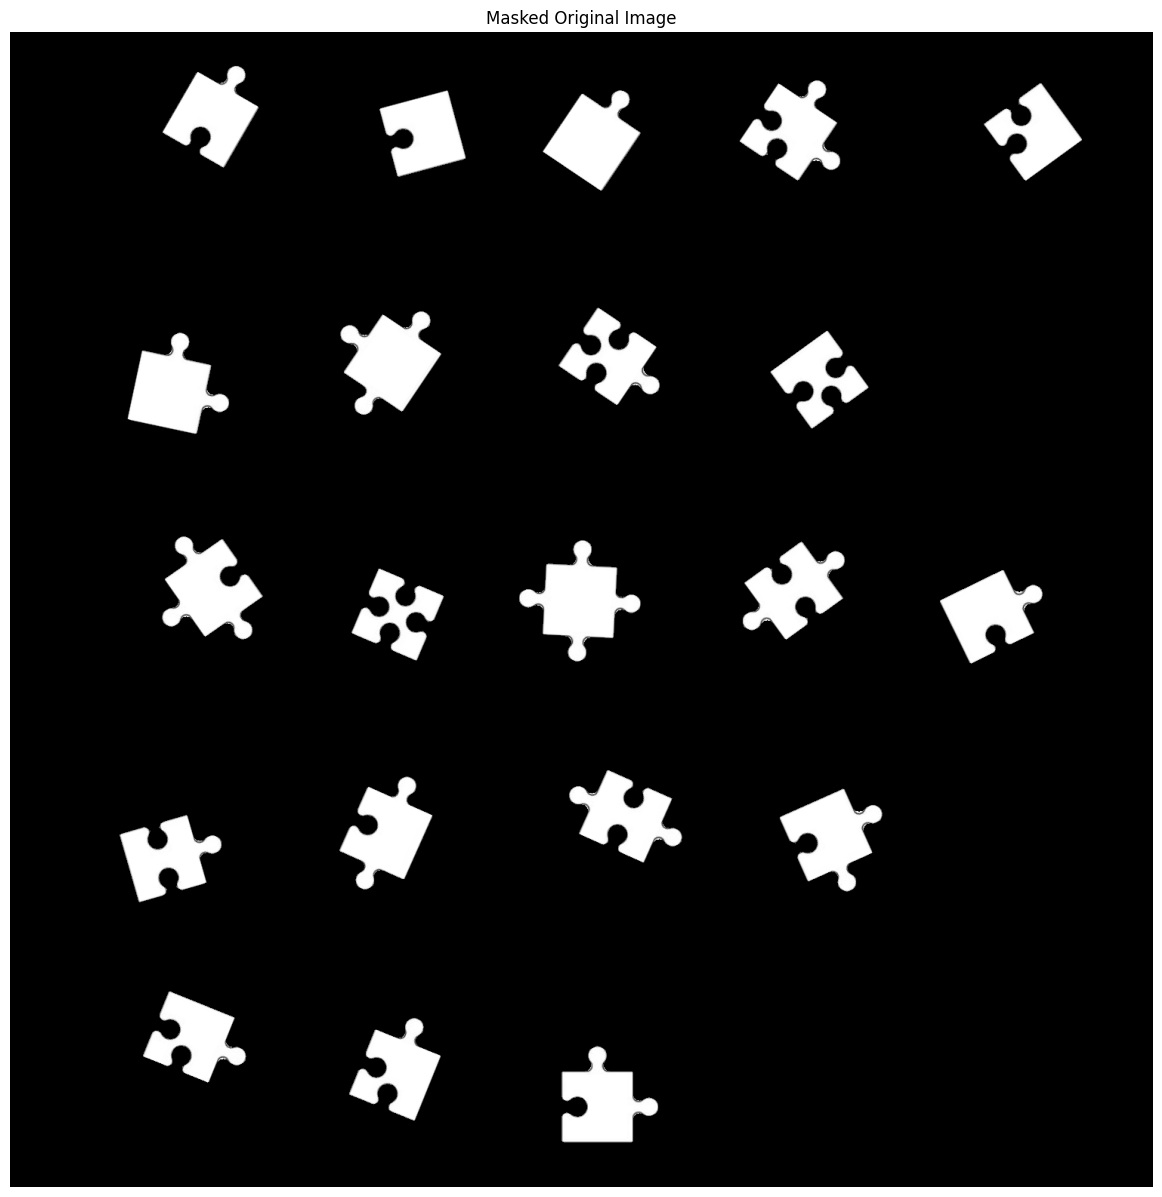

In [11]:
# img_array = cv2.imread('./puzzles/sandwiches.png')
img_seperated = np.copy(img_orig)
img_seperated = np.pad(img_seperated, pad_width=((10, 10), (10, 10), (0, 0)), mode="constant")
filled_pieces = np.copy(filled_pieces)
for x in range(img_seperated.shape[0]):
    for y in range(img_seperated.shape[1]):
        if filled_pieces[x][y] == 0:
            img_seperated[x][y] = [0, 0, 0]
img_seperated = cv2.cvtColor(img_seperated, cv2.COLOR_BGR2RGB)
show(img_seperated, "Masked Original Image")

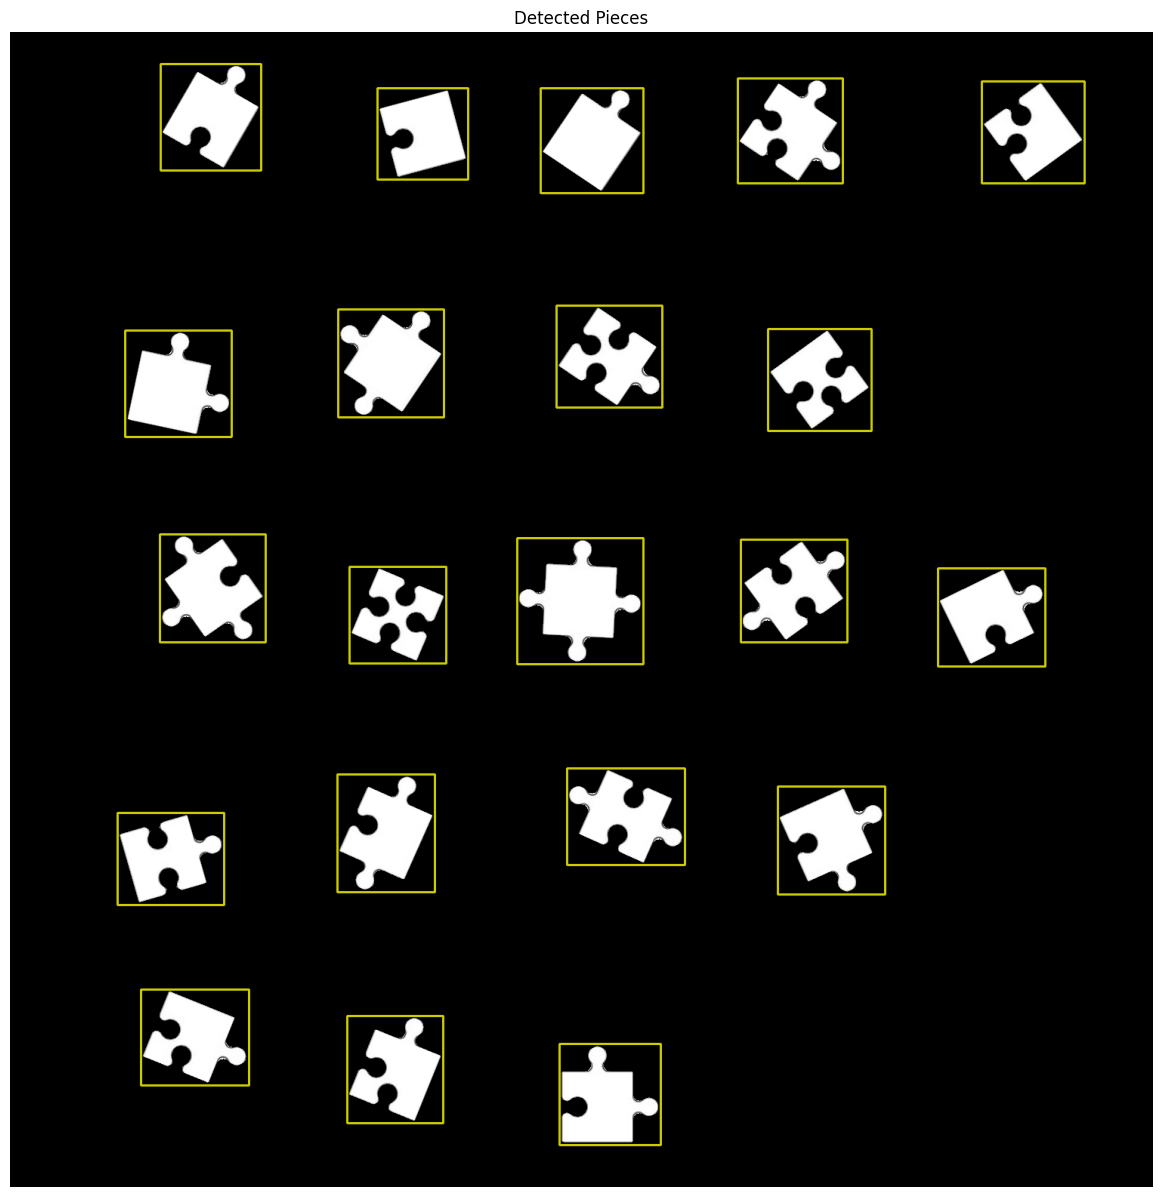

In [12]:
def detect_objects(image, pieces):
    pad =10
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes around each detected object
    img_with_boxes = np.copy(image)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 20 and h > 20:
            cv2.rectangle(img_with_boxes, (x-3, y-3), (x + w + 3, y + h + 3), (204, 204, 0), 2)
            #taking screenshots of the mask
            pieces.append(filled_pieces[y-pad:y+h+pad, x-pad:x+w+pad])
    return img_with_boxes

# Example usage: store pieces
pieces = []
image_pieces_detected = detect_objects(img_seperated, pieces)

# Display the result
show(image_pieces_detected, "Detected Pieces")

Take boundary image, then take center of contour, graph the radius and angle from center.

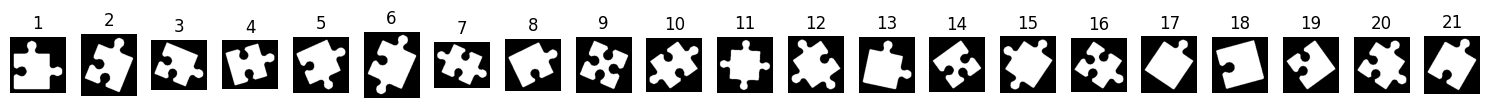

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=len(pieces), figsize=(15, 5))
# Iterate through the array and display each image
for i, image in enumerate(pieces):
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(f"{i+1}")
# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [14]:
def connect_nearby(img, val):
    img_new = np.copy(img)
    img = np.pad(img, val+1,'constant', constant_values=(0, 0))
    diff_grid=[[0,1],[1,0],[0,-1],[-1,0]]
    diff_check= [[-1,0], [0,1],[1,0],[0,-1]]
    img_x, img_y = img.shape
    # print(img.shape)
    for x in range(img_x - val - val-2):
        x_val = x+val+1
        for y in range(img_y - val - val-2):
            y_val = y+val+1
            if(img[x_val][y_val]==255):
                for loop in range(val):
                    curr_x = x_val - (loop+1)
                    curr_y = y_val - (loop+1)
                    iterate = 8*(loop+1)
                    for i in range(iterate):
                        color =0
                        next = (int)(i/(iterate/4))
                        # print(str(curr_x)+ ", "+ str(curr_y))
                        if(i%(iterate/4)==0):
                            if(i ==0):
                                if(img[curr_x][curr_y-1]==255 | img[curr_x-1][curr_y-1]==255 | img[curr_x-1][curr_y]==255):
                                    color =255
                            elif(i== iterate/4):
                                if(img[curr_x-1][curr_y]==255 | img[curr_x-1][curr_y+1]==255 | img[curr_x][curr_y+1]==255):
                                    color =255
                            elif(i== iterate/2):
                                if(img[curr_x][curr_y+1]==255 | img[curr_x+1][curr_y+1]==255 | img[curr_x+1][curr_y]==255):
                                    color =255
                            else:
                                if(img[curr_x+1][curr_y]==255 | img[curr_x+1][curr_y-1]==255 | img[curr_x][curr_y-1]==255):
                                    color =255
                        else:
                            comp_x = curr_x+diff_check[next][0]
                            comp_y = curr_y+diff_check[next][1]
                            if(img[comp_x][comp_y]==255):
                                color=255
                        if(color==255):
                            cv2.line(img_new,(y_val-val-1,x_val-val-1), (curr_y-val-1,curr_x-val-1), 255,1 )
                            # img_new[curr_x-val-1][curr_y-val-1] = 255


                        curr_x = curr_x + diff_grid[next][0]
                        curr_y = curr_y + diff_grid[next][1]
                    
                # print(str(x_val)+ ", "+ str(y_val))
                # print(img[x_val][y_val])
    return img_new


In [15]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
pieces_smoothed = np.empty(len(pieces), dtype=object)
for x, _ in enumerate(pieces):
    erode_img_copy = cv2.erode(pieces[x], kernel)
    pieces_bound = pieces[x] - erode_img_copy
    pieces_smoothed[x] = cv2.bitwise_or(pieces[x], connect_nearby(pieces_bound, 5))

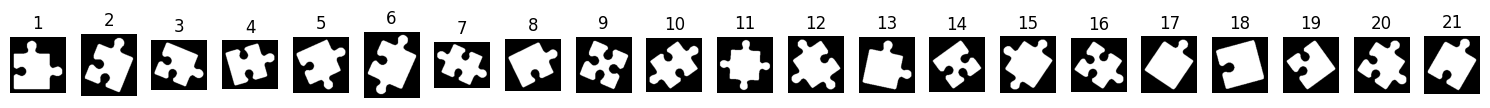

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=len(pieces), figsize=(15, 5))
# Iterate through the array and display each image
for i, image in enumerate(pieces_smoothed):
    pad_len = (int)(len(image)/5)
    pieces_smoothed[i] = cv2.copyMakeBorder(image,pad_len,pad_len,pad_len,pad_len,cv2.BORDER_CONSTANT,value=0)
    image = pieces_smoothed[i]
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(f"{i+1}")
# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [17]:
def find_rmse(X,Y,m, c, n):
    rmse = 0
    for i in range(n):
        a = m
        b = -1
        d = abs((a * X[i] + b * Y[i] + c)) / (math.sqrt(a * a + b * b))
        rmse += d
        # y_pred = c + m * X[i]
        # rmse += (Y[i] - y_pred) ** 2
    rmse =(rmse/n)
    return rmse

In [18]:
def find_angle(array_line1_x, array_line1_y,array_line2_x, array_line2_y, half):
    # slope1, yinter1= np.polyfit(array_line1_x, array_line1_y, 1)
    # slope2, yinter2= np.polyfit(array_line2_x, array_line2_y, 1)
    line1reg = linregress(array_line1_x, array_line1_y)
    line2reg = linregress(array_line2_x, array_line2_y)
    slope1 = line1reg.slope
    slope2 = line2reg.slope
    yinter1 = line1reg.intercept
    yinter2 = line2reg.intercept
    PI = 3.14159265
    taninv = abs((slope2 - slope1) / (1 + slope1 * slope2))
    ret = math.atan(taninv)
    angle = (ret * 180) / PI
    val=0
    if(angle>75 and angle<100):
        val = 150
    else:
        val =0
    rsme = find_rmse(array_line1_x, array_line1_y, slope1, yinter1, half) +find_rmse(array_line2_x, array_line2_y, slope2, yinter2, half)
    # rsme = line1reg.stderr + line2reg.stderr
    if(rsme>(1)):
        val = 0
    return val, rsme

In [19]:
def find_biggestsquare(list_elements):
    big_area=0
    arr=[]
    for i in list_elements:
        for j in list_elements:
            for k in list_elements:
                for l in list_elements:
                    first = i[0]*j[1] + j[0]*k[1] + k[0]*l[1] + l[0]*i[1]
                    second = j[0]*i[1] + k[0]*j[1] + l[0]*k[1] + i[0]*l[1]
                    area = 0.5*(first - second)
                    if(area>big_area):
                        big_area = area
                        arr.clear()
                        arr.append(i)
                        arr.append(j)
                        arr.append(k)
                        arr.append(l)

    return arr
                        

In [53]:

def add_elem(xval, yval,array_line1_x, array_line1_y, pointer_line1, array_line2_x, array_line2_y, pointer_line2, half):
    array_line2_x[pointer_line2] = xval
    array_line2_y[pointer_line2] = yval
    pointer_line2 = (pointer_line2+1)%half
    array_line2_x[pointer_line2] = array_line2_x[pointer_line2]+0.001
    array_line1_x[pointer_line1] = array_line2_x[pointer_line2]
    array_line1_y[pointer_line1] = array_line2_y[pointer_line2]
    pointer_line1 = (pointer_line1+1)%half
    array_line1_x[pointer_line1] = array_line1_x[pointer_line1]+0.001
    return pointer_line1, pointer_line2

def find_corners(find_corner_image):
    completed = False
    pieces_drawbound = np.copy(find_corner_image)

    i=0
    j=0

    while(pieces_drawbound[i+1][j+1]!=255):
        i=i+1
        j=j+1

    # pieces_drawbound[i][j] = 200
    # show_gray(pieces_drawbound,"")
    
    size = len(pieces_drawbound)/4

    half = (int)((size+1)/2)
    array_line1_x = [0 for element in range(half)]
    array_line1_y = [0 for element in range(half)]
    pointer_line1 = 0
    array_line2_x = [1 for element in range(half)]
    array_line2_y = [1 for element in range(half)]
    pointer_line2 = 0

    list_elements = []

    direction =0 #0 is up, 1 is right, 2 is down and 3 is left
    move = [[-1,0],[0,1],[1,0],[0,-1]]
    initial_i = i
    initial_j = j
    counter = 0
    counter_add = 0
    while (not(completed) and counter<5000):
        counter= counter+1
        index = direction
        top_piece = pieces_drawbound[i+move[index%4][0]][j+move[index%4][1]]
        index = index +1
        right_piece = pieces_drawbound[i+move[index%4][0]][j+move[index%4][1]]
        if(right_piece==255):
            if(top_piece==255):
                direction = direction-1
            else:
                pointer_line1,pointer_line2 = add_elem(i,j,array_line1_x, array_line1_y, pointer_line1, array_line2_x, array_line2_y, pointer_line2, half)
                counter_add = counter_add+1

                if(counter_add==(half-1)):
                    initial_i = i
                    initial_j = j
            
                
                if(counter_add>=size):
                    val, rsme = find_angle(array_line1_x, array_line1_y,array_line2_x, array_line2_y, half)
                    if(val>0):
                        list_elements.append([int(array_line2_x[pointer_line2]),int(array_line2_y[pointer_line2]), rsme])
                    # pieces_drawbound[array_line2_x[pointer_line2]][array_line2_y[pointer_line2]] = val
                    if(int(array_line2_x[pointer_line2])==initial_i and int(array_line2_y[pointer_line2])==initial_j):
                        completed = True

                

                i = i+move[direction%4][0]
                j = j+move[direction%4][1]
        else:
            pointer_line1,pointer_line2 = add_elem(i,j,array_line1_x, array_line1_y, pointer_line1, array_line2_x, array_line2_y, pointer_line2, half)
            
            counter_add = counter_add+1
        
            if(counter_add==(half-1)):
                initial_i = i
                initial_j = j

            if(counter_add>=size):
                val, rmse = find_angle(array_line1_x, array_line1_y,array_line2_x, array_line2_y, half)
                if(val>0):
                    list_elements.append([int(array_line2_x[pointer_line2]),int(array_line2_y[pointer_line2]), rmse])
                # pieces_drawbound[array_line2_x[pointer_line2]][array_line2_y[pointer_line2]] = val
                if(int(array_line2_x[pointer_line2])==initial_i and int(array_line2_y[pointer_line2])==initial_j):
                    completed = True


            direction = direction+1
            i = i+move[direction%4][0]
            j = j+move[direction%4][1]
    # final = find_biggestsquare(list_elements)

    final_list = []
    local_min = list_elements[0][2]
    local_x = list_elements[0][0]
    local_y = list_elements[0][1]
    # final_list = list_elements
    for i in range(1,len(list_elements)):
        # print(list_elements[i])
        x = list_elements[i][0]
        y = list_elements[i][1]
        prev_x = list_elements[i-1][0]
        prev_y = list_elements[i-1][1]
        if((x>prev_x-2 and x<prev_x+2) and (y>prev_y-2 and y<prev_y+2)):
            if(list_elements[i][2]<local_min):
                local_min = list_elements[i][2]
                local_x = x
                local_y = y
        else:
            final_list.append([local_x, local_y, local_min])
            # print("hi")
            local_min = list_elements[i][2]
            local_x = x
            local_y = y
    final_list.append([local_x, local_y, local_min])

    final = find_biggestsquare(final_list)

    for i in final:
        # cv2.circle(pieces_drawbound, (int(i[0]) , int(i[1])), 2, (200),2)
        pieces_drawbound[int(i[0])][int(i[1])]=150


    # for i in final:
        # pieces_drawbound[i[0]][i[1]]=150
    return pieces_drawbound, [(i[0], i[1]) for i in final]
pieces_corner_coordinates = []
pieces_corner_drawn = []
for i in pieces_smoothed:
    piece_with_corner, corners = find_corners(i)
    pieces_corner_coordinates.append(corners)
    pieces_corner_drawn.append(piece_with_corner)
    # show_gray(piece_with_corner,"")
print(len(pieces_corner_drawn), len(pieces_corner_coordinates))

21 21


[(103, 9), (104, 90), (10, 90), (9, 9)]
[(9, 43), (56, 42), (57, 137), (10, 138)]
[(11, 138), (10, 90), (103, 90), (104, 138)]
[(138, 137), (57, 138), (57, 43), (137, 42)]


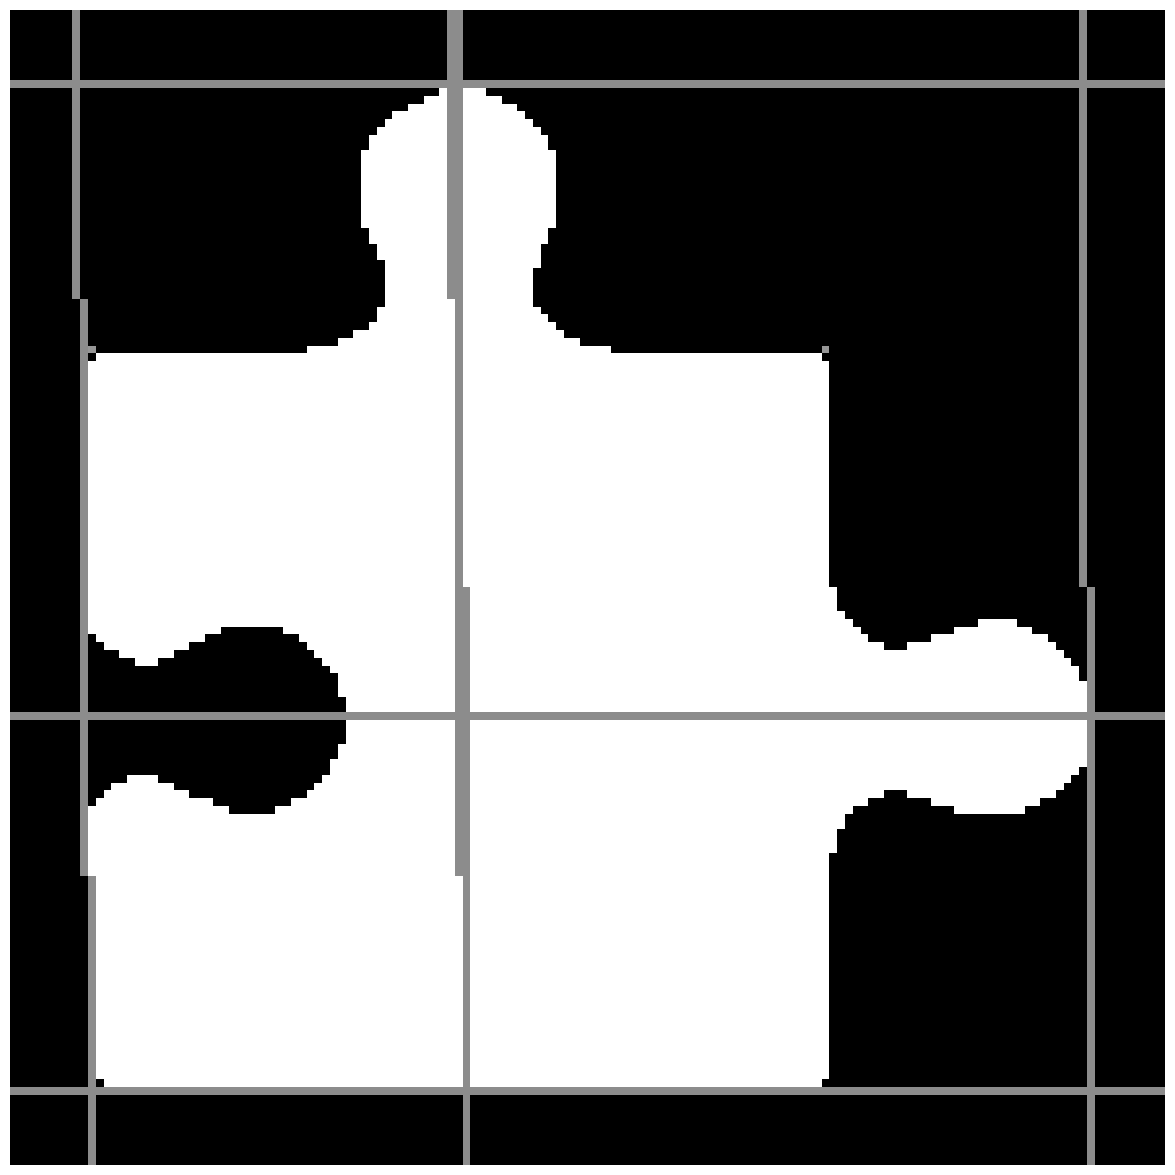

[(42, 23), (87, 41), (52, 128), (7, 110)]
[(8, 112), (26, 67), (114, 102), (96, 147)]
[(98, 146), (53, 128), (87, 42), (132, 60)]
[(144, 27), (113, 103), (26, 67), (57, -8)]


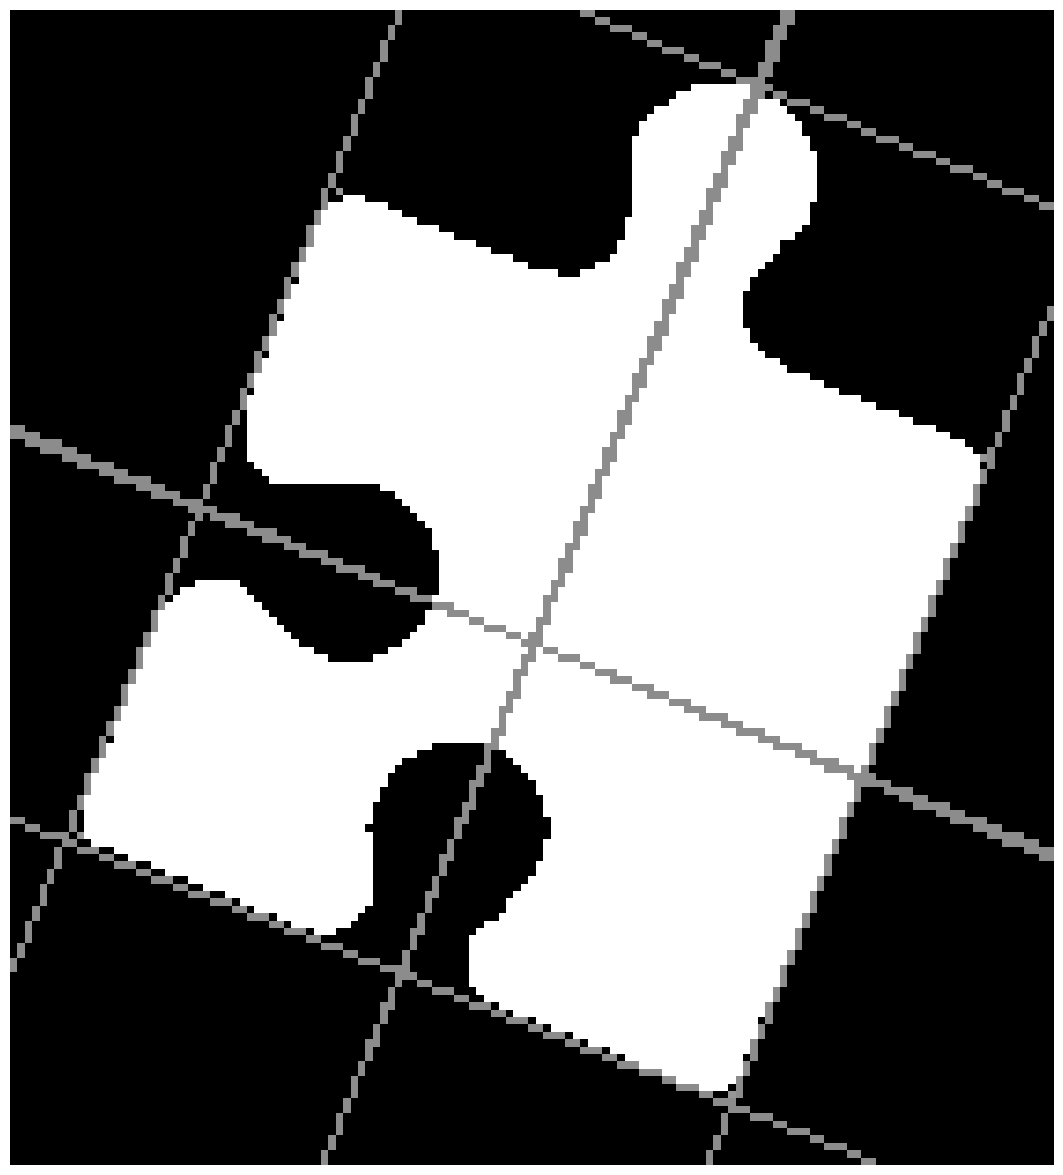

[(42, 8), (87, 26), (53, 113), (8, 95)]
[(8, 97), (25, 52), (112, 86), (95, 131)]
[(128, 143), (52, 111), (88, 25), (164, 57)]
[(132, 42), (114, 87), (25, 52), (43, 7)]


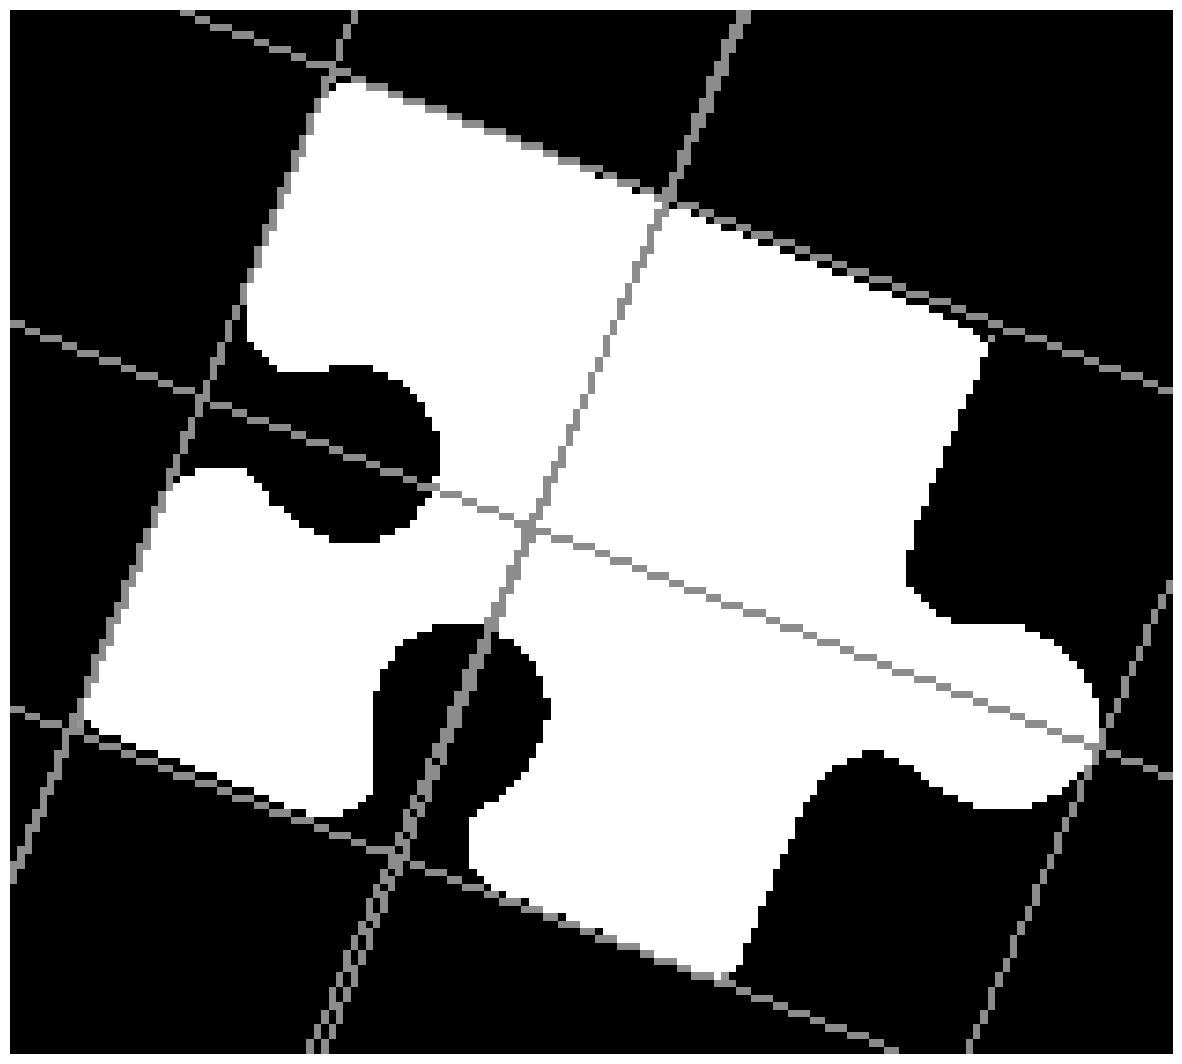

[(98, 8), (112, 54), (22, 80), (8, 34)]
[(8, 35), (54, 22), (80, 113), (34, 126)]
[(35, 127), (21, 80), (111, 54), (125, 101)]
[(158, 90), (79, 112), (53, 21), (132, 0)]


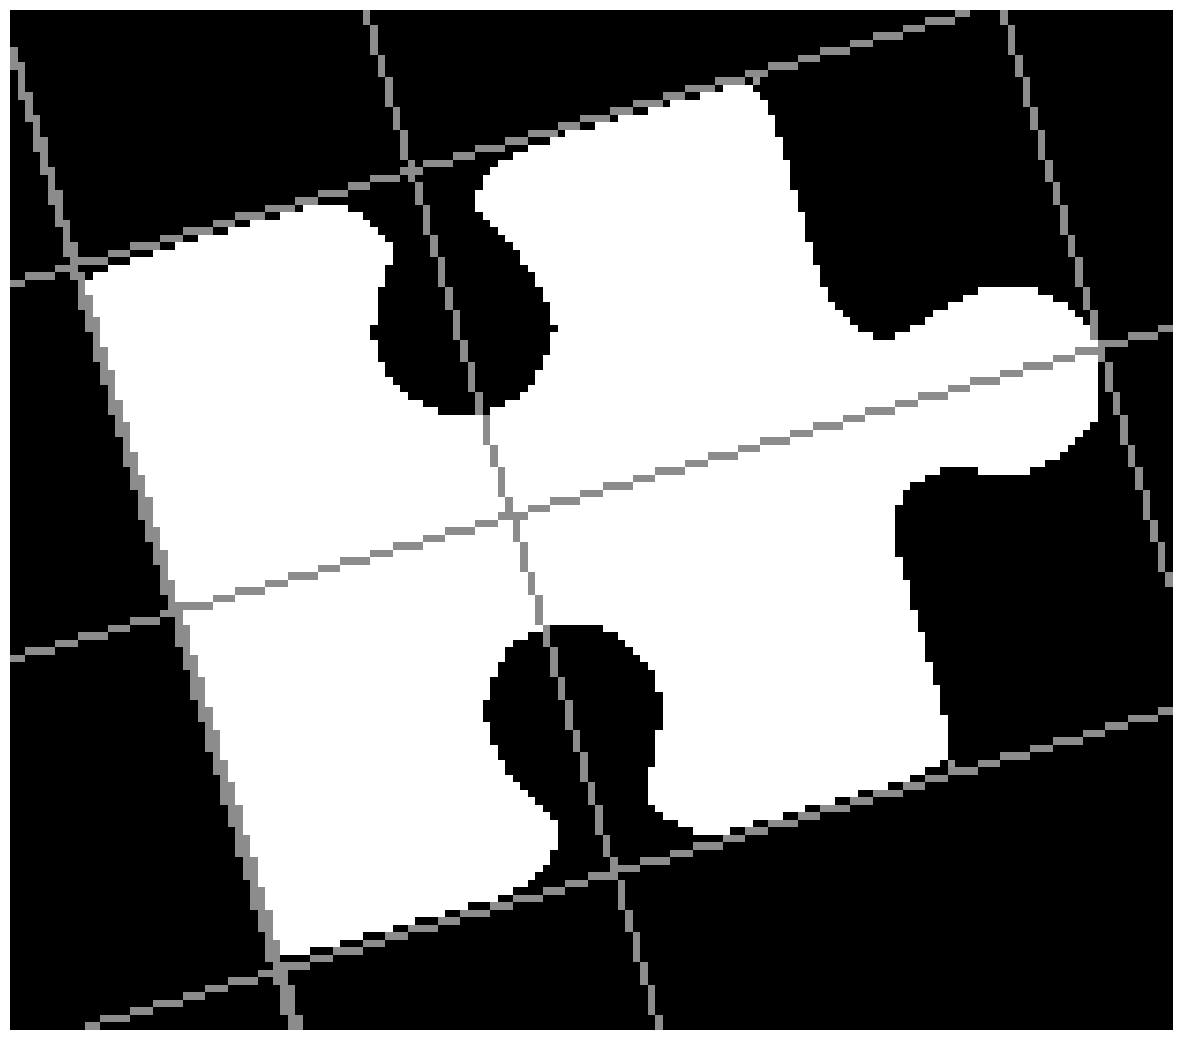

[(93, 8), (113, 51), (28, 90), (8, 47)]
[(7, 48), (52, 29), (89, 114), (44, 133)]
[(60, 165), (27, 90), (114, 52), (147, 127)]
[(164, 80), (90, 114), (51, 28), (125, -5)]


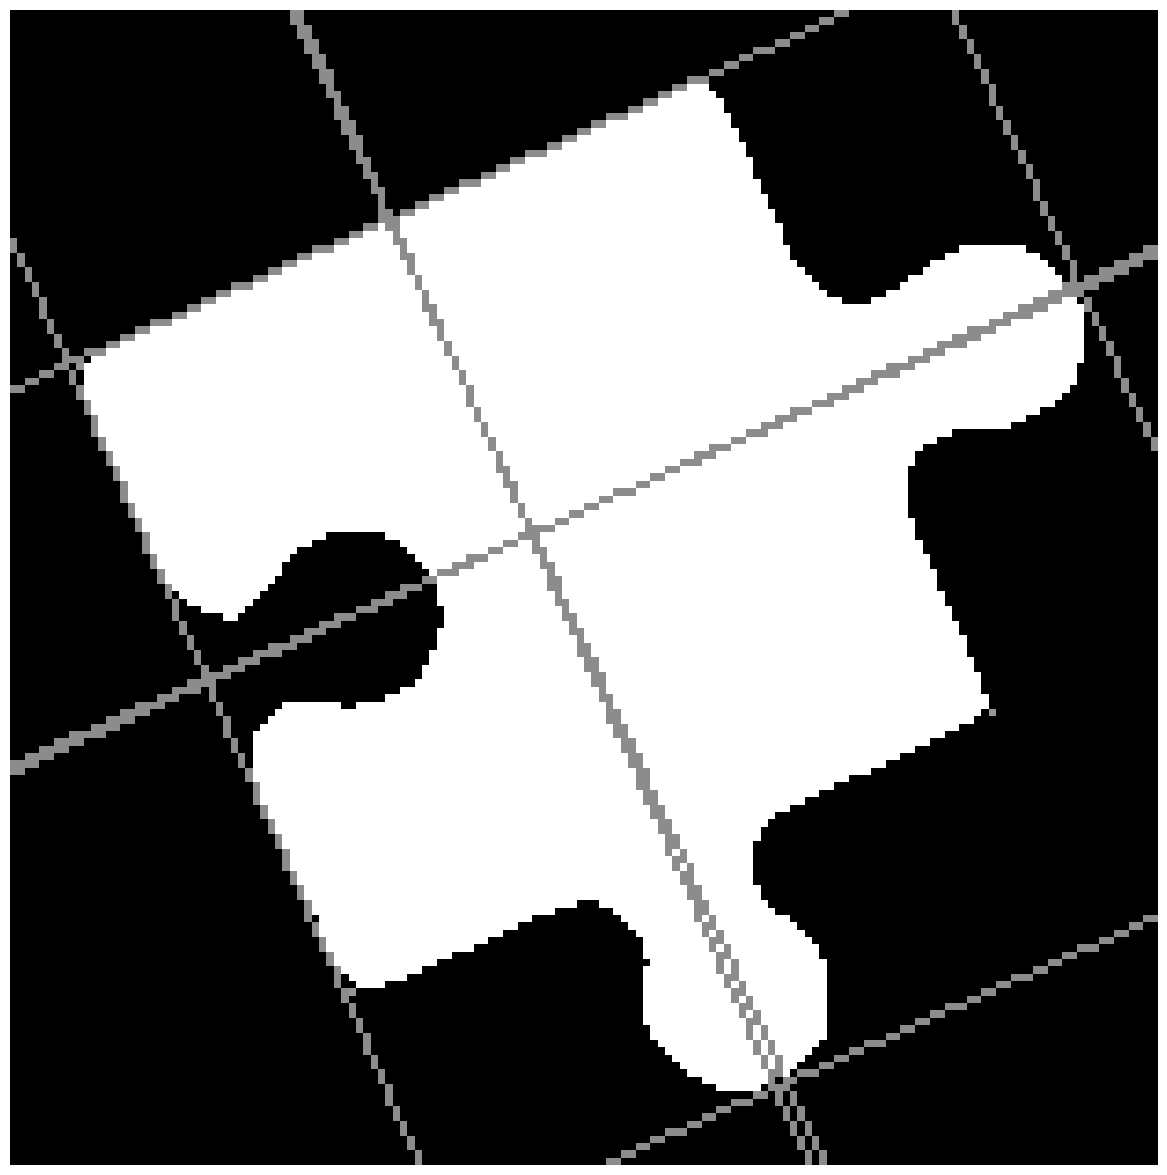

[(46, 22), (90, 42), (52, 127), (8, 107)]
[(-4, 139), (27, 65), (115, 103), (83, 177)]
[(98, 146), (53, 127), (89, 42), (134, 61)]
[(147, 29), (114, 103), (28, 65), (61, -8)]


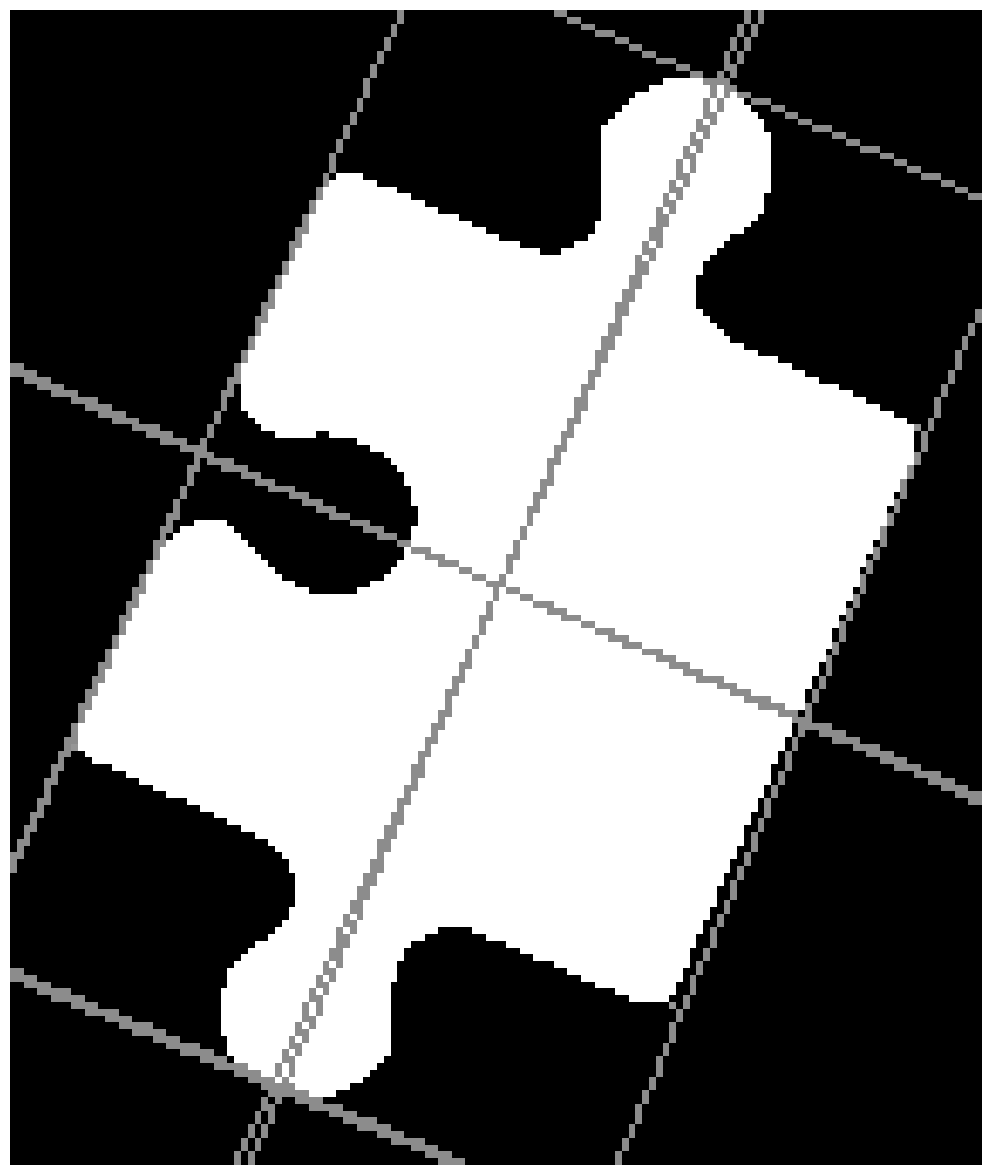

[(29, -4), (103, 28), (65, 113), (-8, 80)]
[(21, 95), (40, 51), (127, 89), (108, 133)]
[(140, 146), (65, 112), (103, 26), (178, 60)]
[(147, 44), (128, 89), (41, 52), (60, 7)]


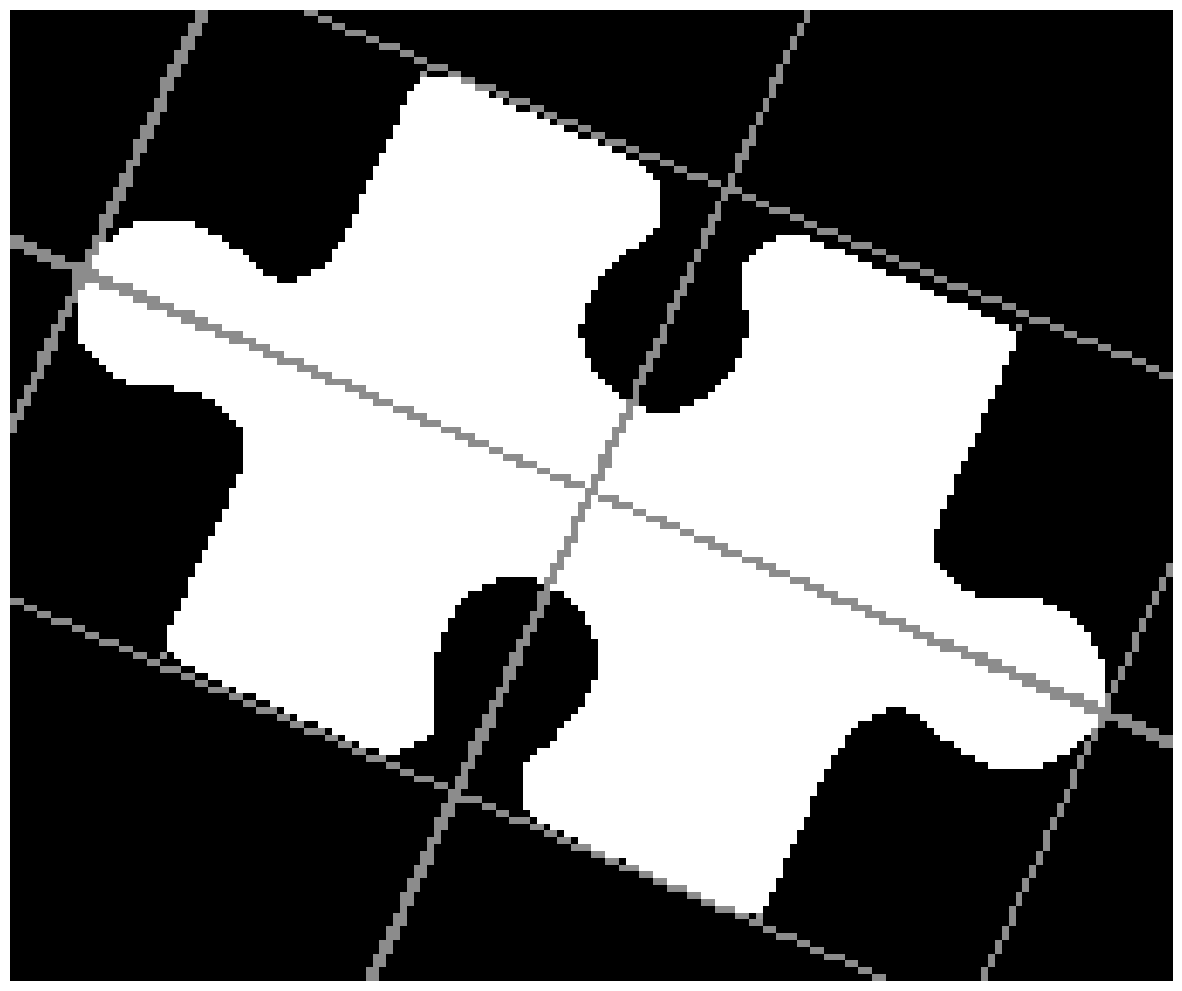

[(93, 7), (114, 51), (29, 92), (8, 48)]
[(7, 50), (51, 29), (92, 113), (48, 134)]
[(50, 134), (29, 91), (114, 50), (135, 93)]
[(166, 77), (92, 113), (51, 29), (125, -6)]


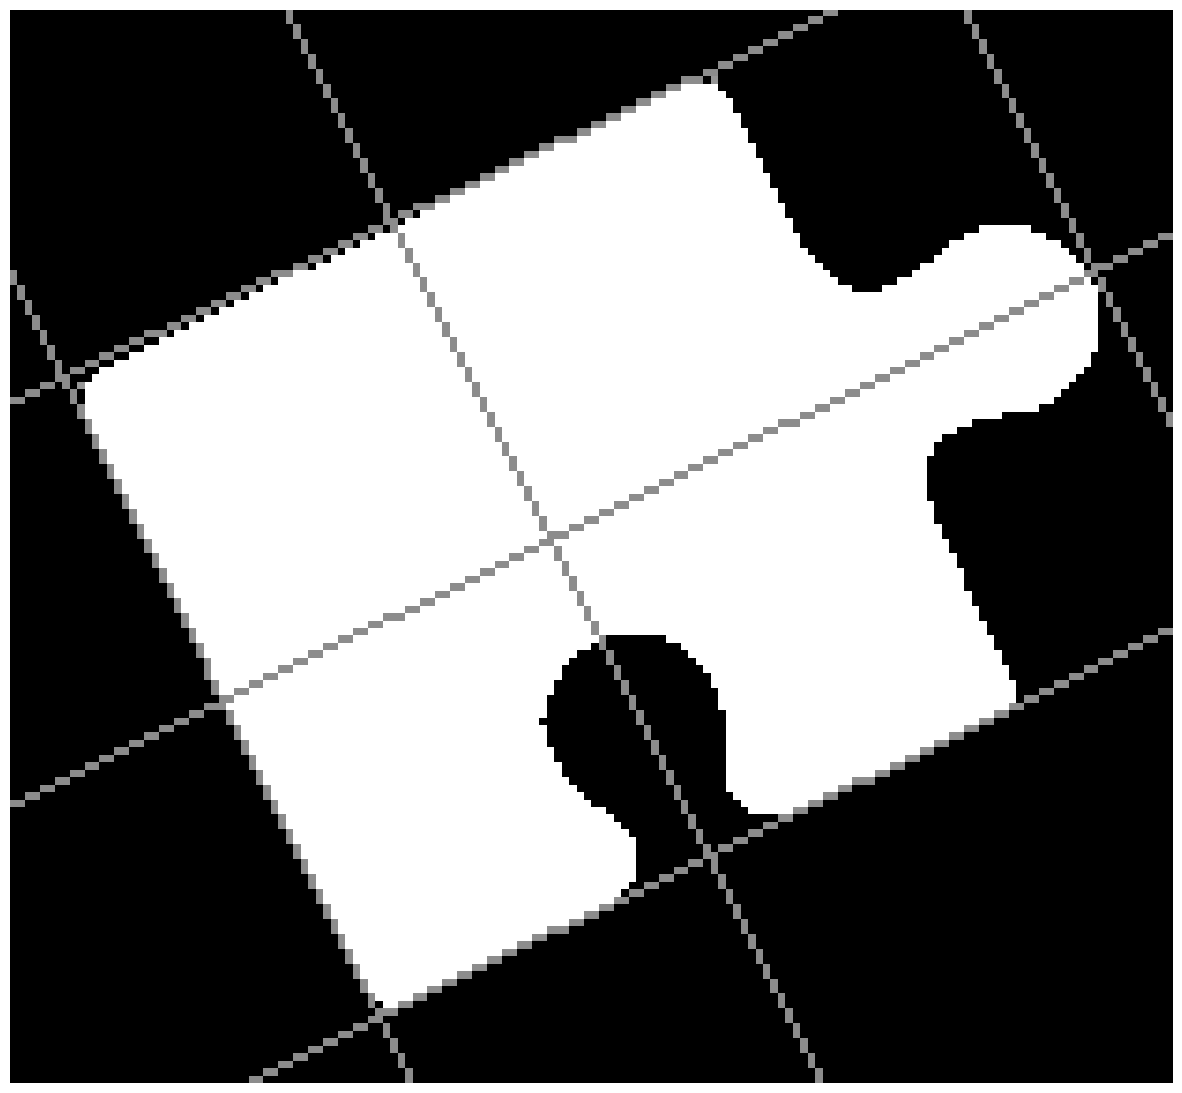

[(43, 8), (87, 26), (52, 112), (8, 94)]
[(8, 96), (27, 51), (114, 88), (95, 133)]
[(98, 132), (52, 113), (88, 26), (134, 45)]
[(132, 43), (114, 88), (26, 52), (44, 7)]


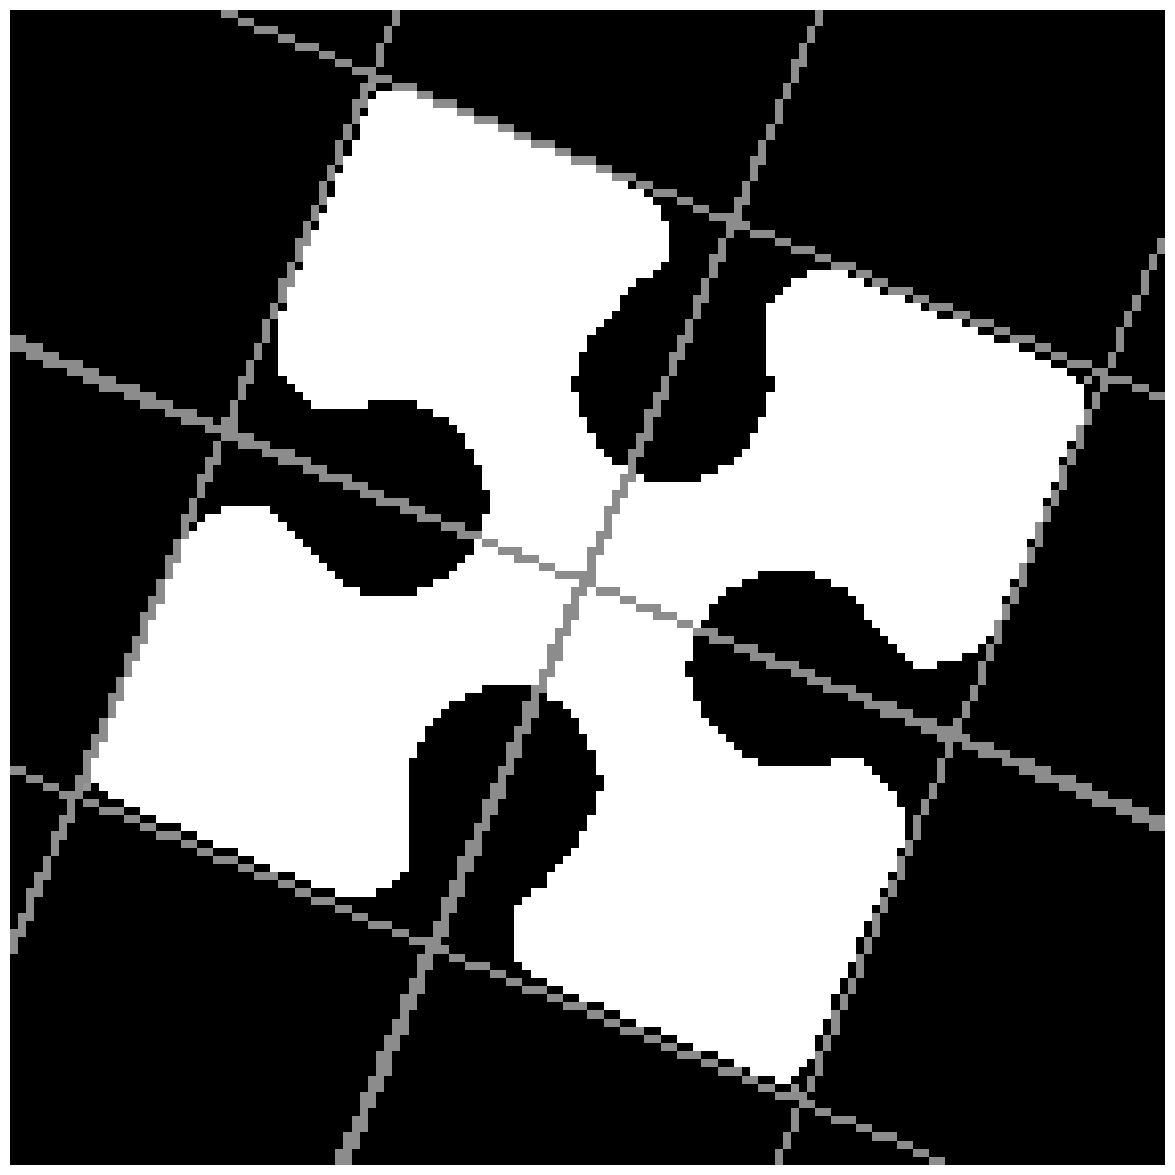

[(86, 8), (114, 47), (38, 102), (10, 63)]
[(-16, 83), (49, 36), (104, 112), (38, 159)]
[(66, 141), (38, 101), (115, 46), (143, 86)]
[(171, 64), (105, 112), (49, 36), (115, -11)]


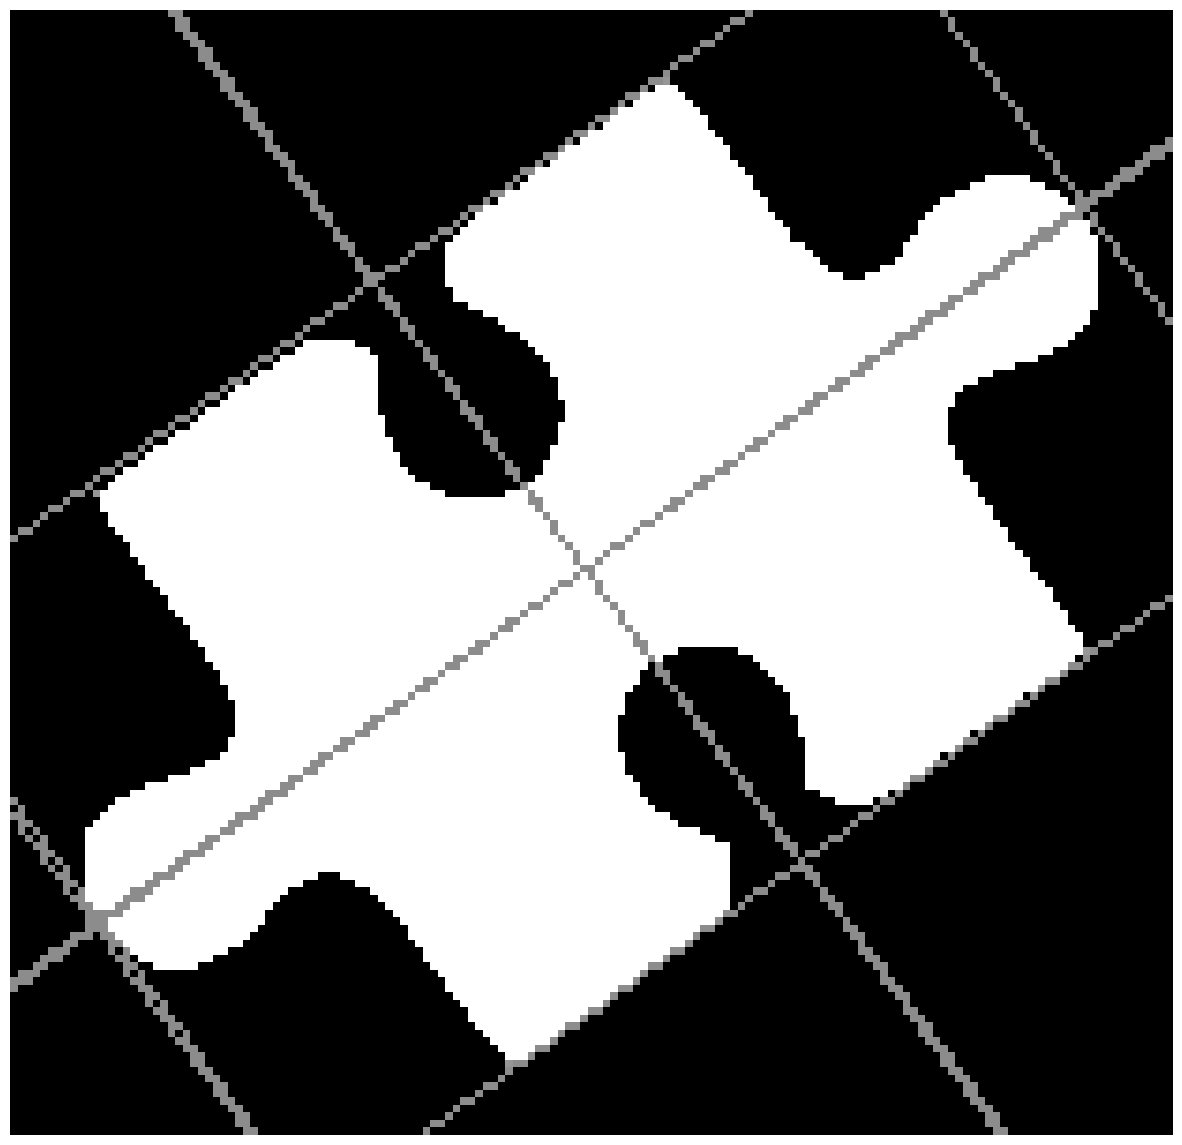

[(142, 12), (136, 93), (43, 87), (49, 6)]
[(12, 37), (93, 42), (87, 137), (6, 132)]
[(39, 168), (43, 87), (136, 92), (132, 173)]
[(168, 142), (87, 137), (93, 43), (174, 48)]


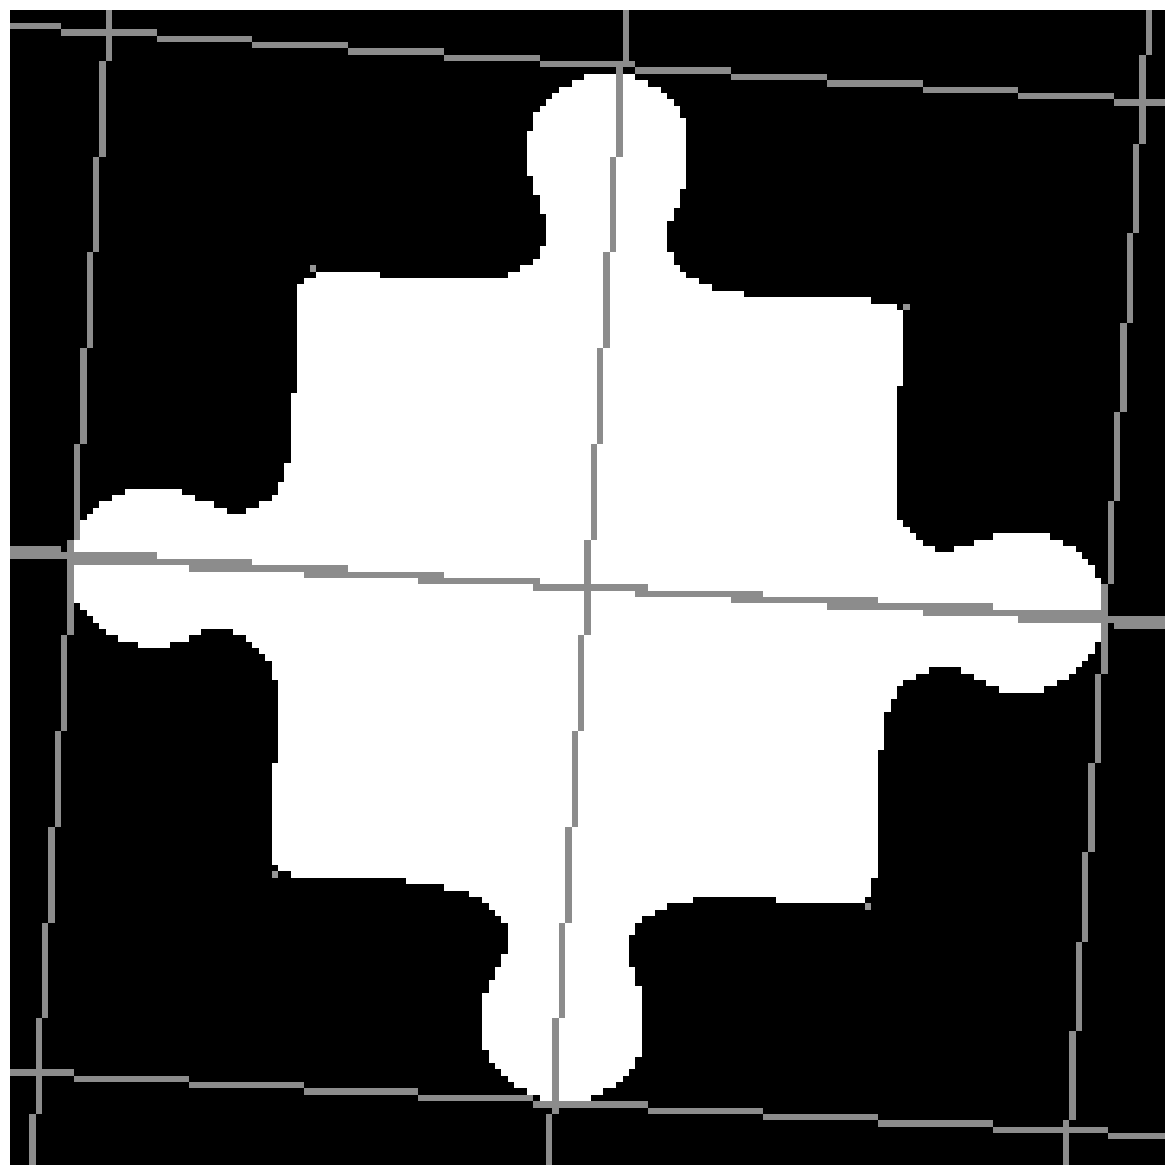

[(70, -15), (116, 51), (39, 104), (-6, 37)]
[(-14, 84), (51, 39), (104, 116), (38, 161)]
[(86, 172), (39, 104), (117, 50), (164, 118)]
[(145, 87), (105, 116), (51, 40), (91, 11)]


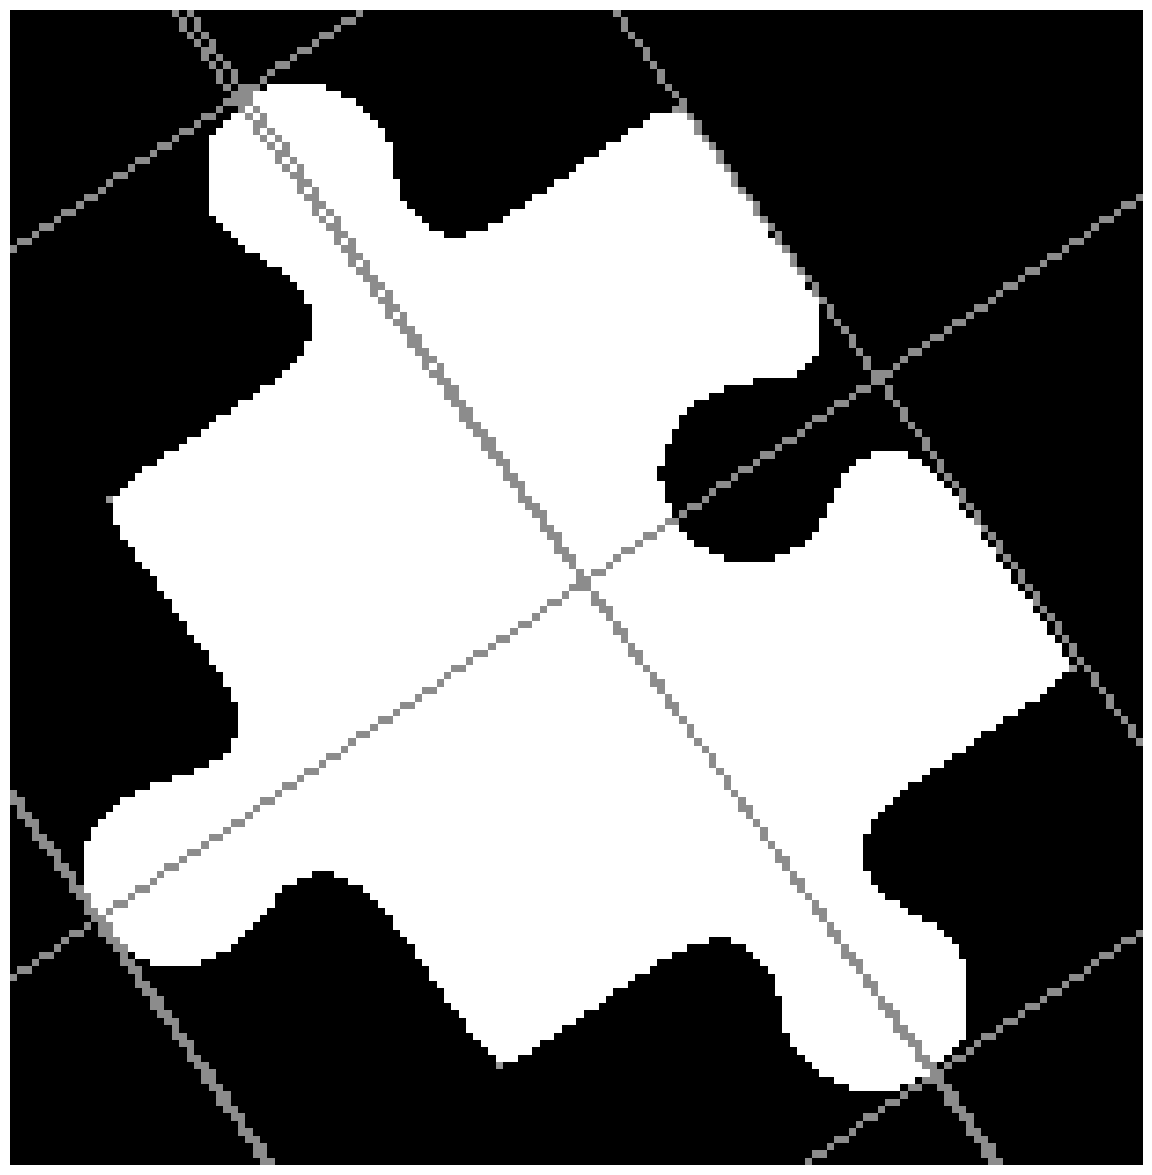

[(127, 19), (111, 97), (19, 78), (35, 0)]
[(28, 32), (74, 43), (54, 134), (8, 123)]
[(8, 126), (18, 78), (110, 98), (100, 146)]
[(135, 151), (55, 134), (75, 42), (155, 59)]


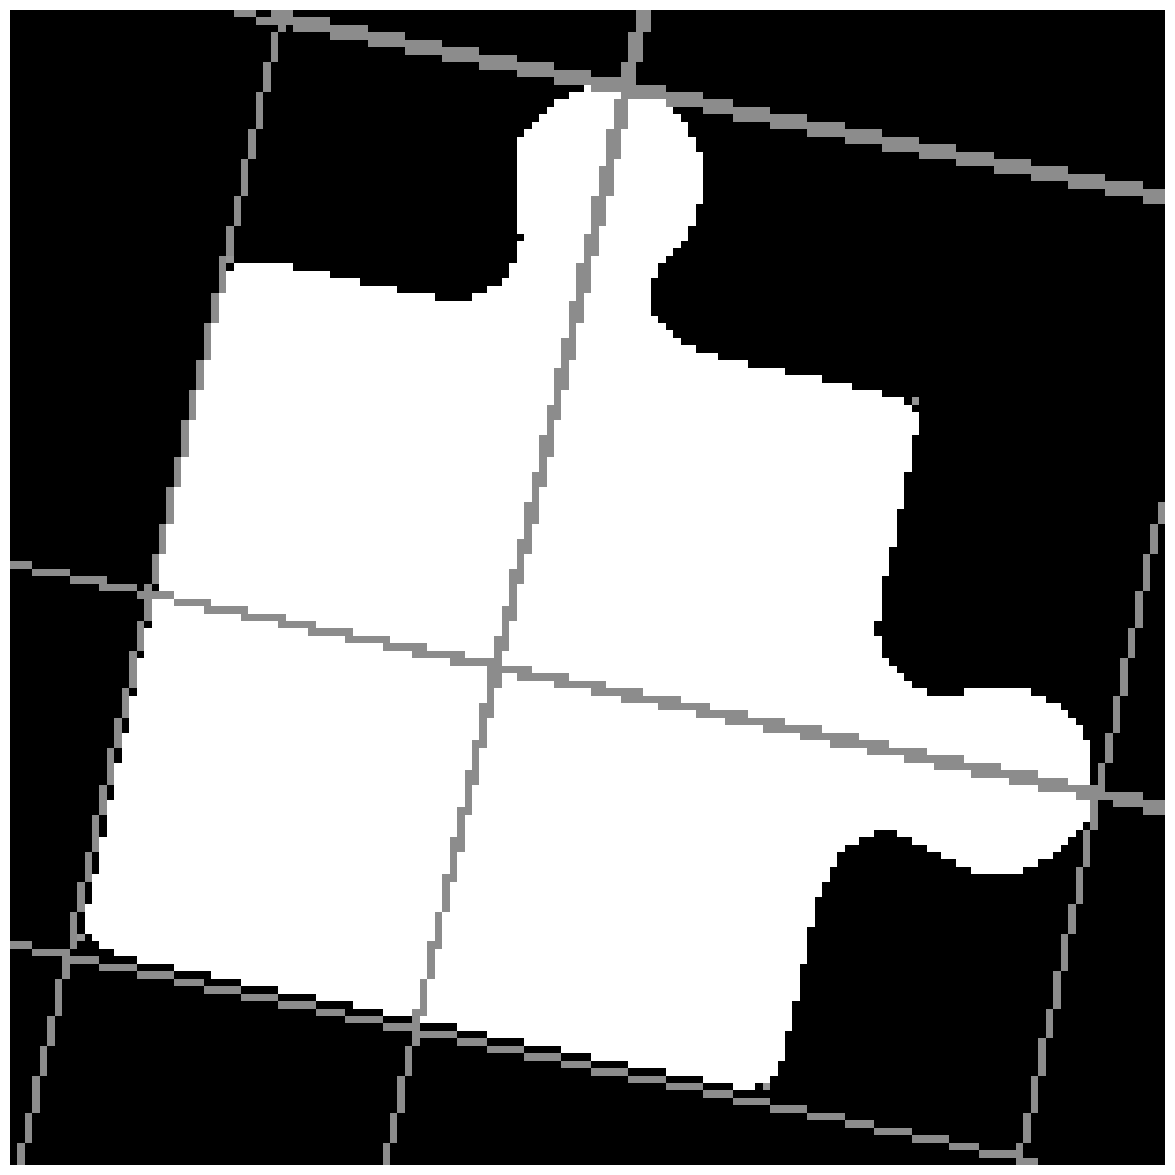

[(83, 7), (111, 46), (36, 102), (8, 63)]
[(7, 66), (46, 36), (102, 110), (63, 140)]
[(65, 140), (37, 101), (113, 46), (141, 85)]
[(143, 82), (103, 112), (46, 37), (86, 7)]


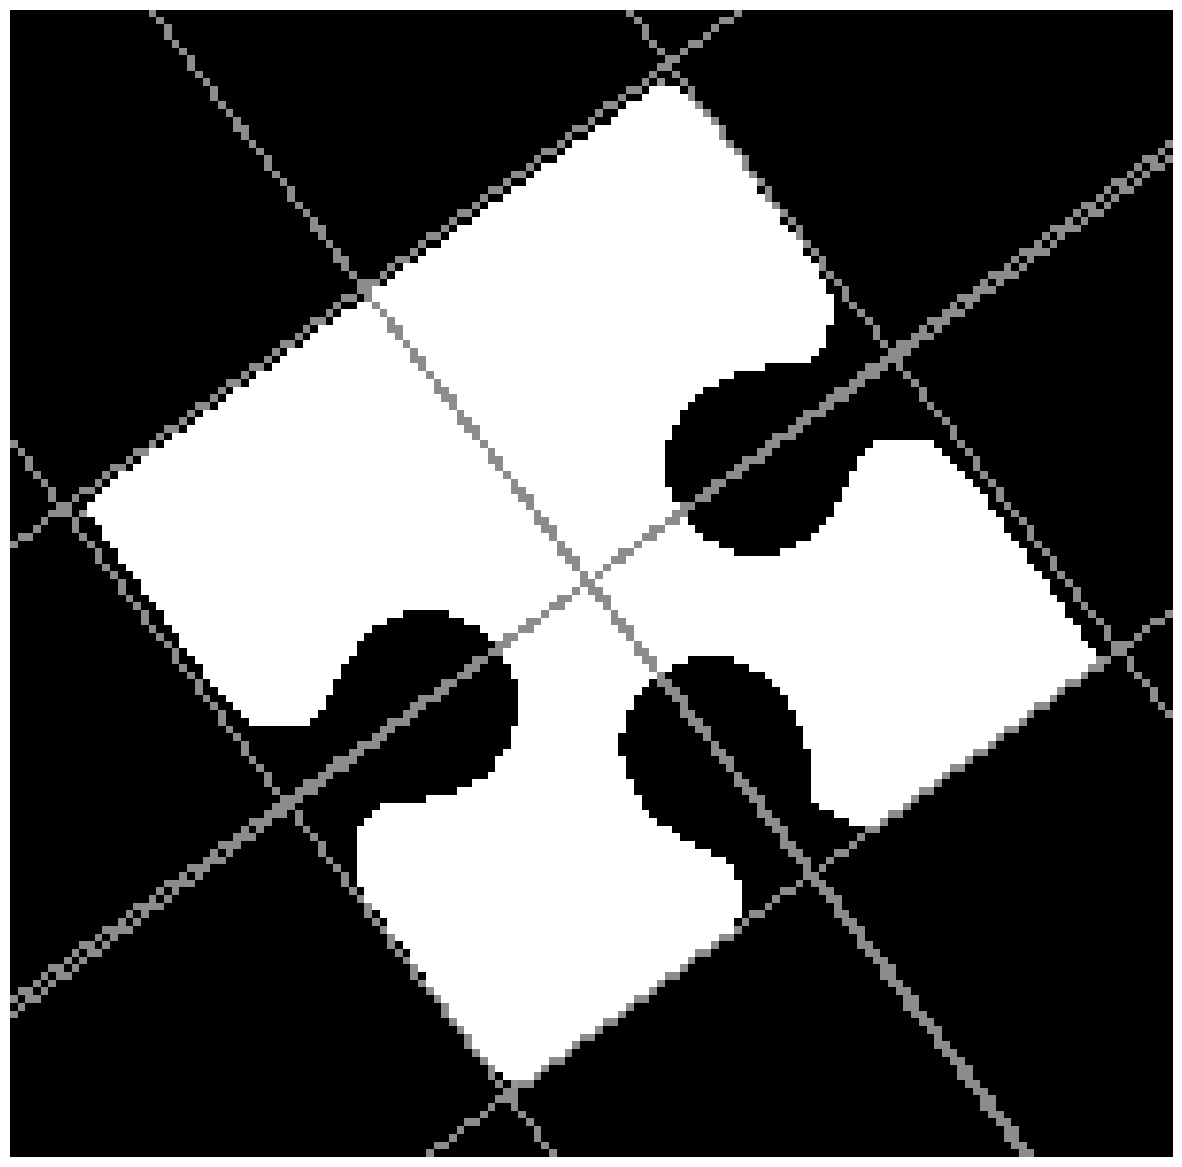

[(38, -5), (104, 39), (52, 116), (-13, 71)]
[(-4, 117), (40, 51), (117, 104), (72, 170)]
[(92, 144), (52, 116), (105, 39), (145, 67)]
[(163, 37), (117, 104), (39, 51), (85, -15)]


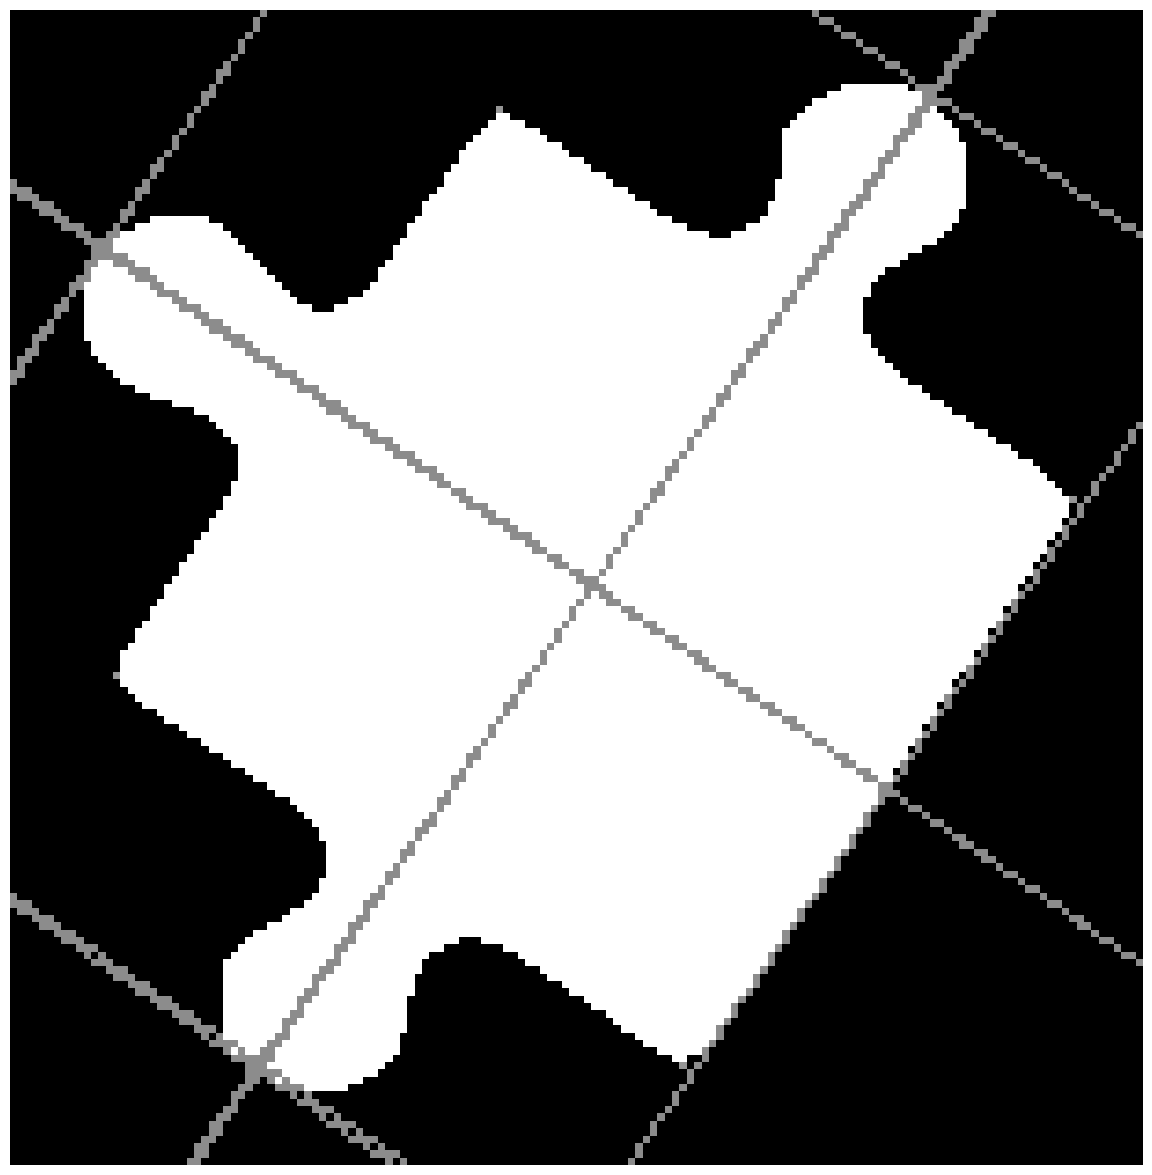

[(61, 8), (101, 35), (48, 113), (8, 86)]
[(8, 88), (34, 48), (112, 100), (86, 140)]
[(115, 158), (48, 112), (101, 36), (168, 82)]
[(141, 60), (113, 101), (35, 47), (63, 6)]


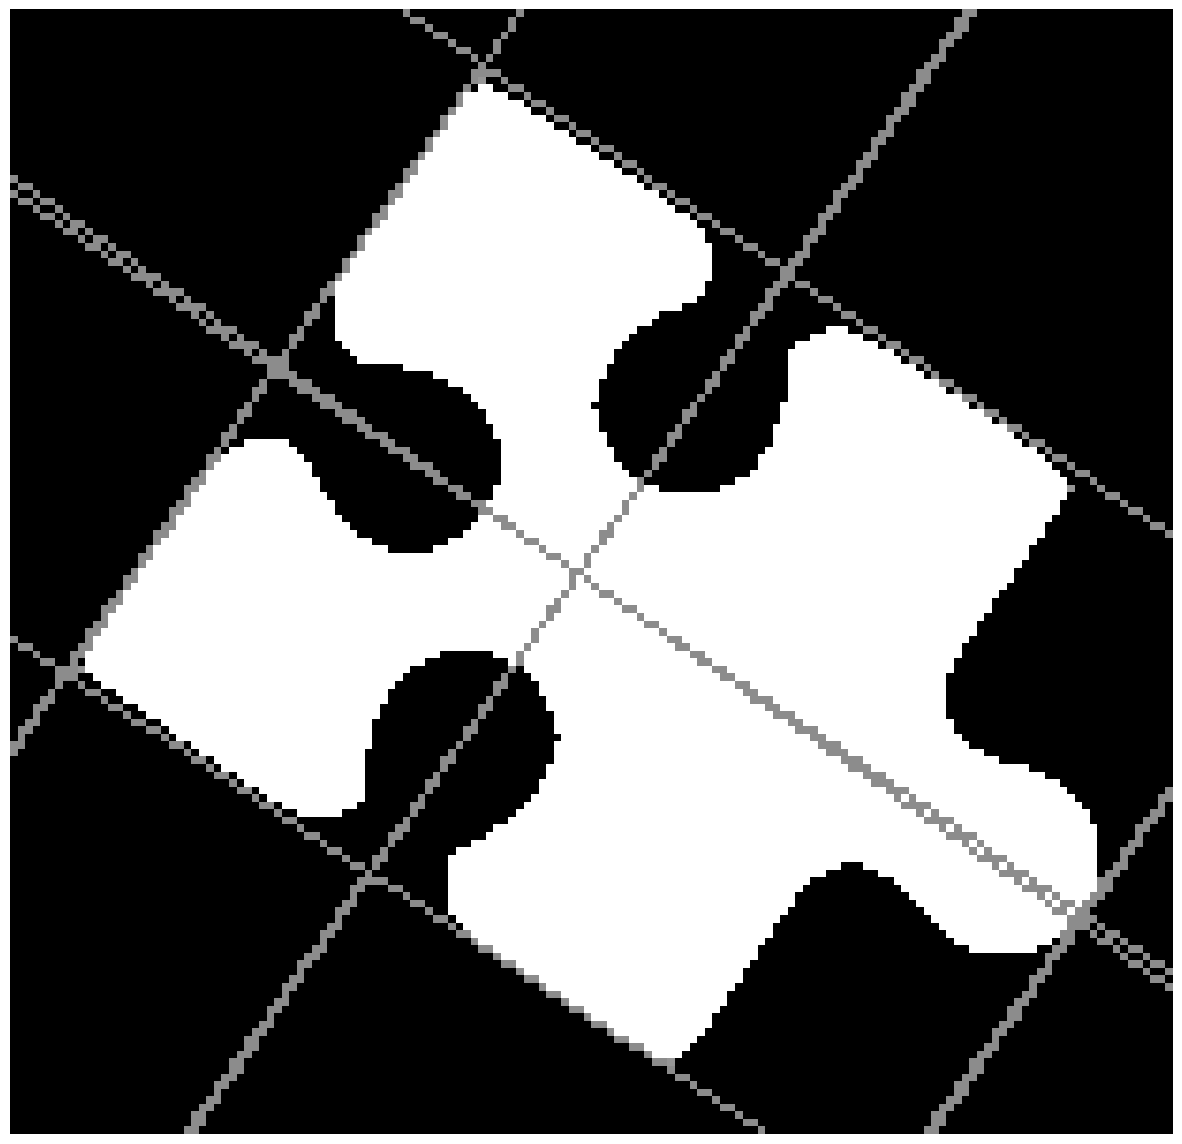

[(61, 12), (101, 40), (47, 117), (7, 89)]
[(8, 92), (35, 52), (113, 104), (86, 144)]
[(89, 144), (48, 116), (101, 39), (142, 67)]
[(159, 37), (113, 104), (36, 52), (82, -14)]


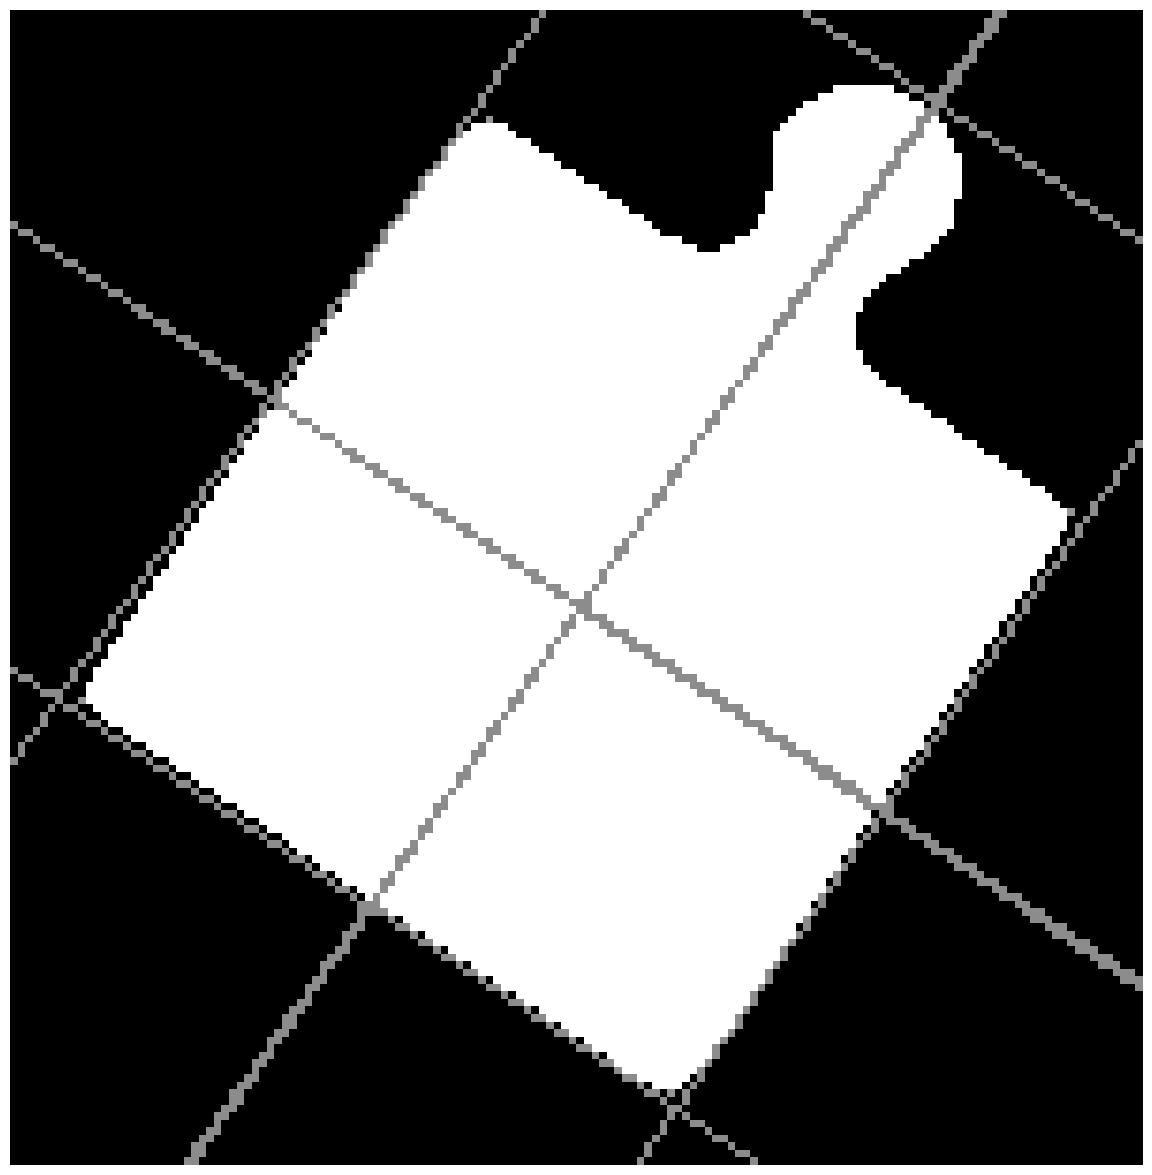

[(98, 8), (111, 54), (21, 79), (8, 33)]
[(8, 34), (54, 22), (78, 113), (32, 125)]
[(33, 126), (20, 79), (111, 55), (124, 102)]
[(126, 100), (78, 113), (53, 21), (101, 8)]


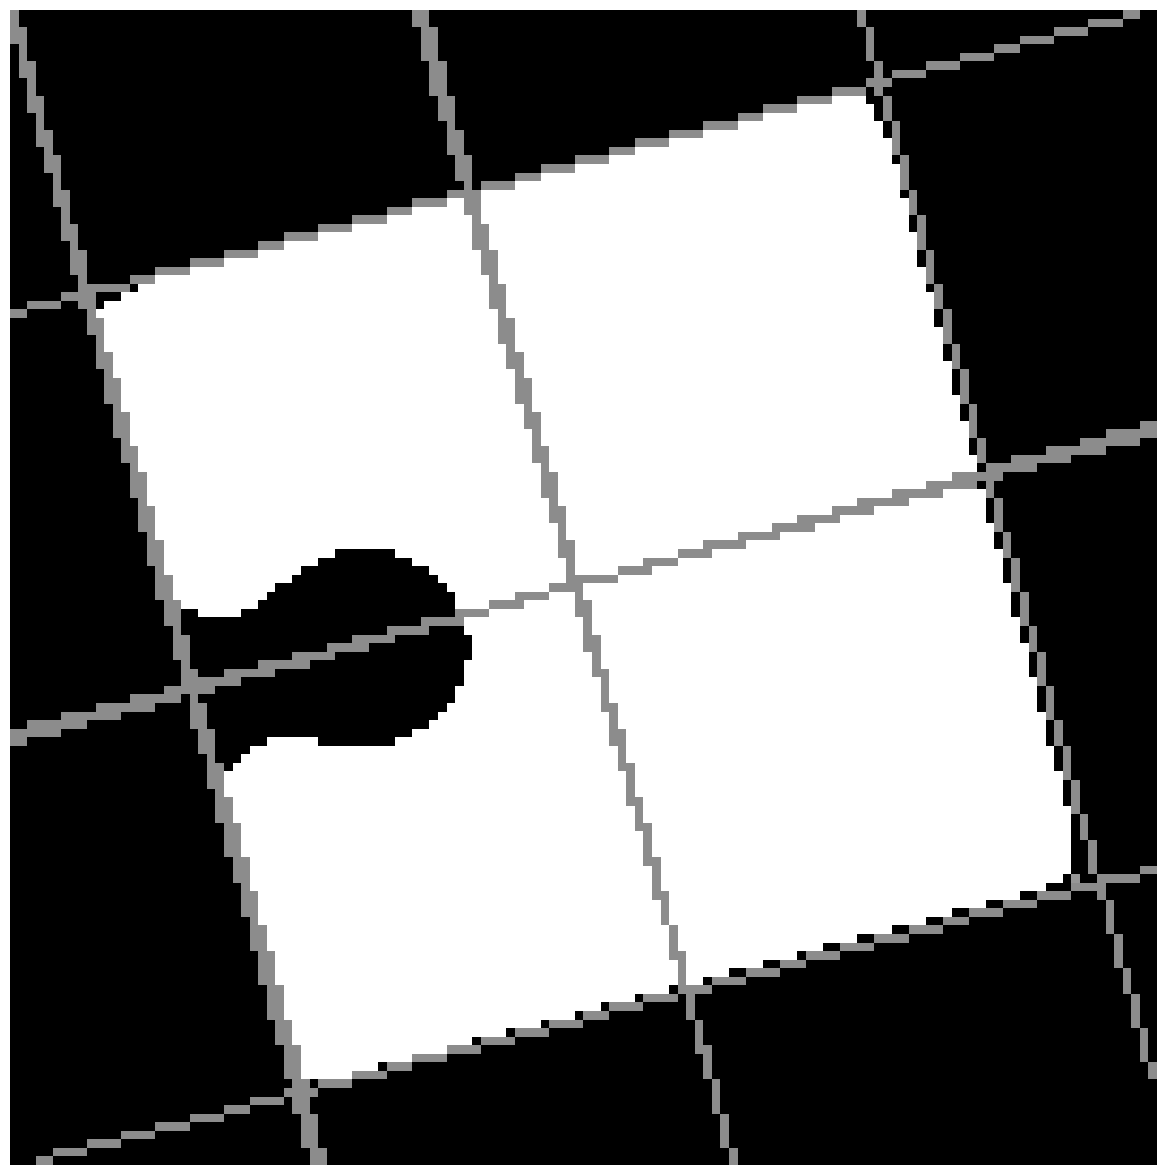

[(84, 7), (112, 47), (36, 101), (8, 61)]
[(7, 64), (46, 35), (101, 111), (62, 140)]
[(65, 140), (36, 100), (112, 46), (141, 86)]
[(141, 83), (102, 112), (47, 36), (86, 7)]


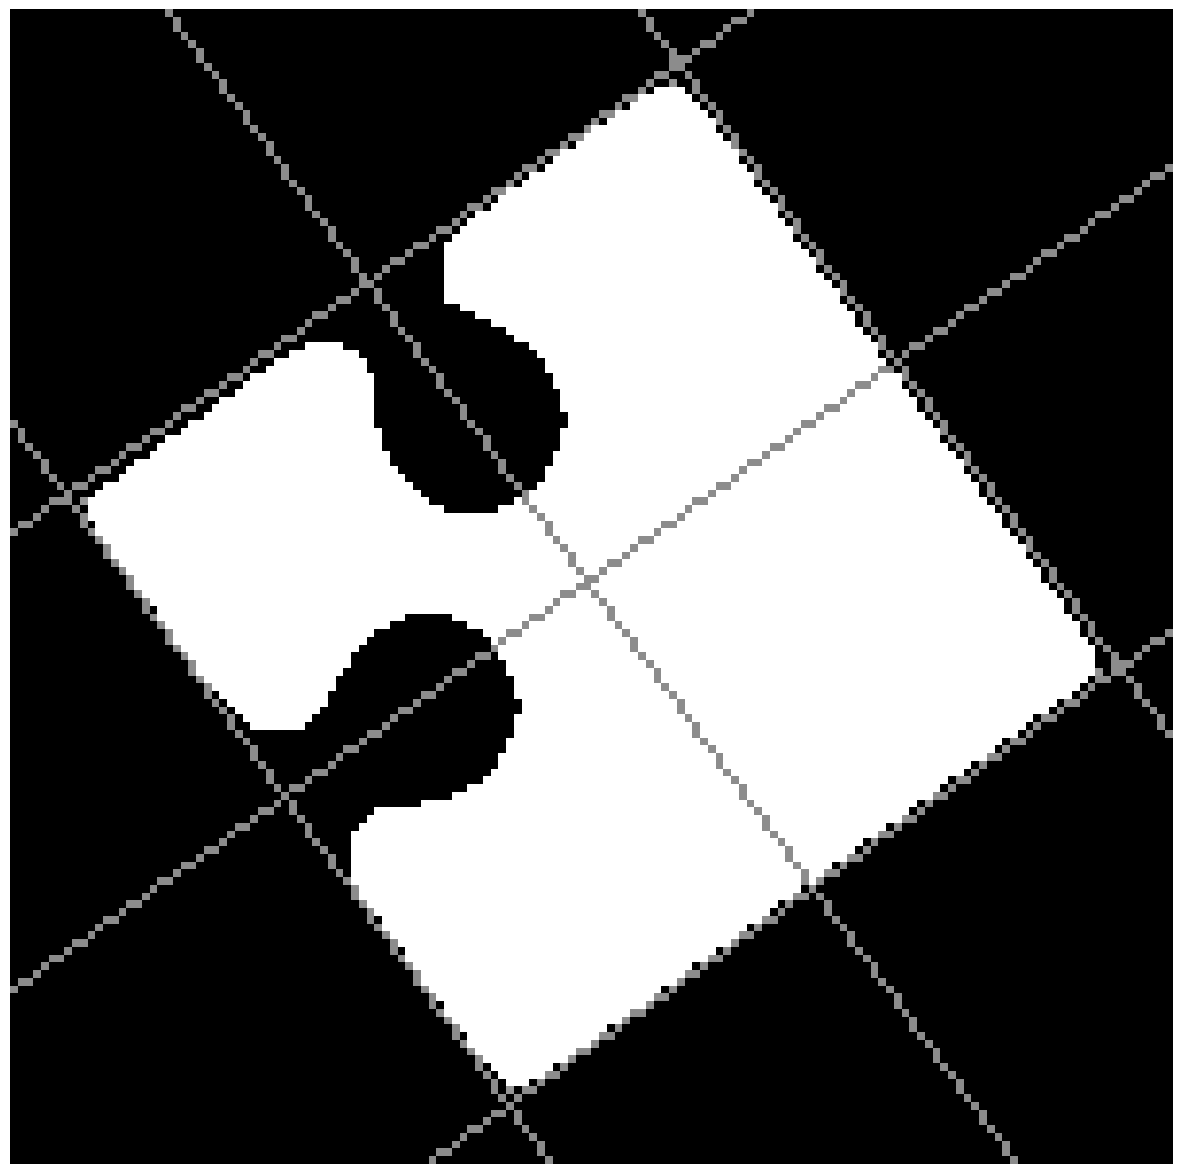

[(60, 12), (99, 39), (47, 116), (8, 89)]
[(7, 92), (35, 51), (113, 104), (85, 145)]
[(115, 162), (47, 116), (99, 38), (167, 84)]
[(157, 36), (113, 103), (35, 51), (79, -15)]


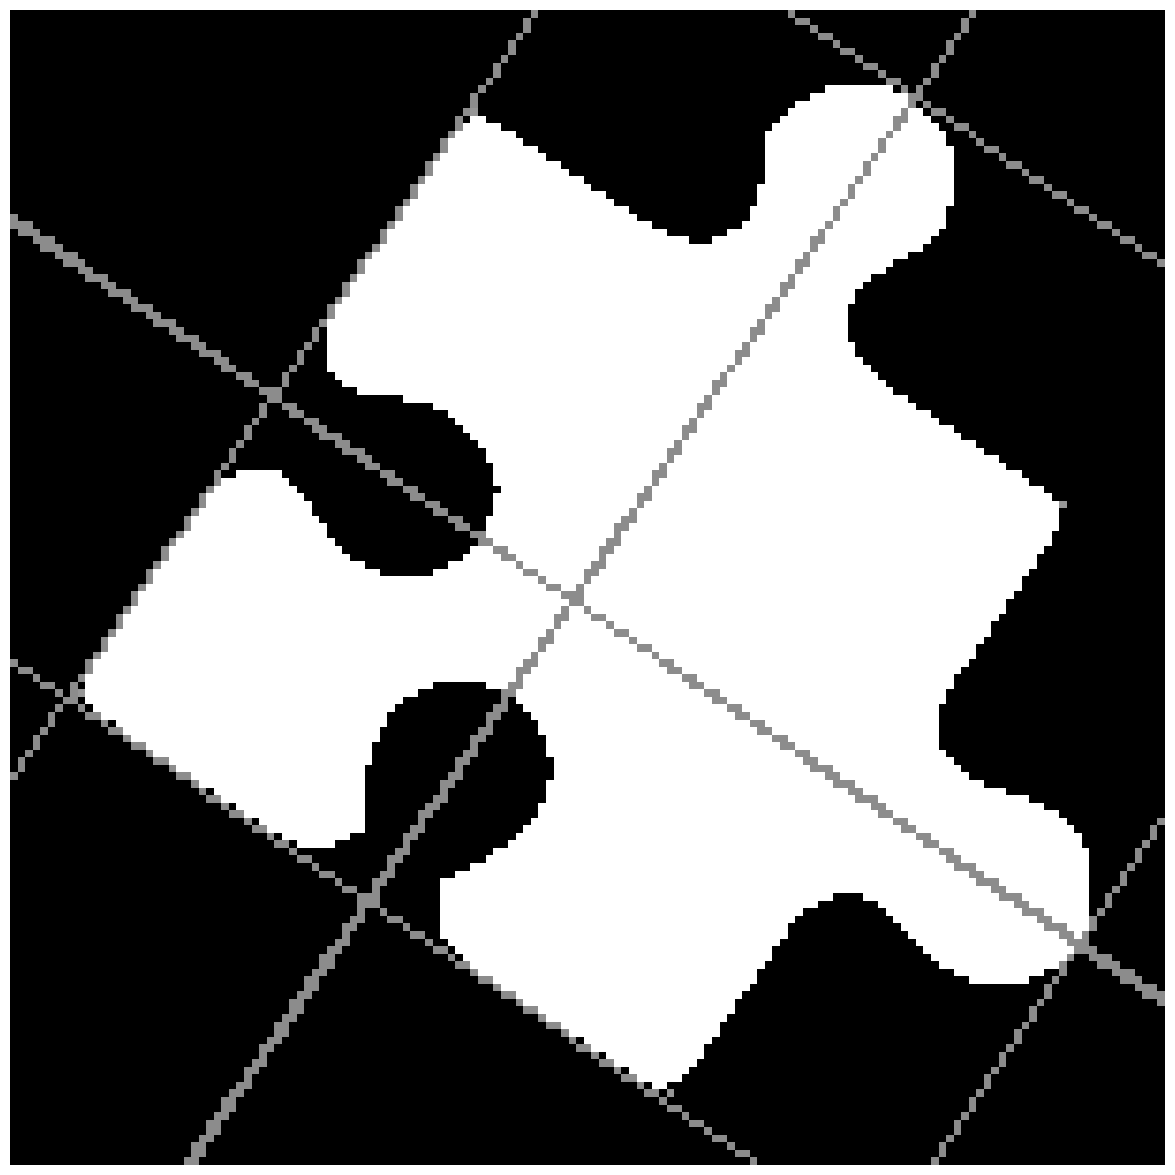

[(53, 16), (95, 40), (49, 121), (7, 97)]
[(8, 99), (32, 57), (113, 104), (89, 146)]
[(91, 146), (49, 121), (96, 40), (138, 65)]
[(154, 33), (113, 104), (31, 57), (72, -13)]


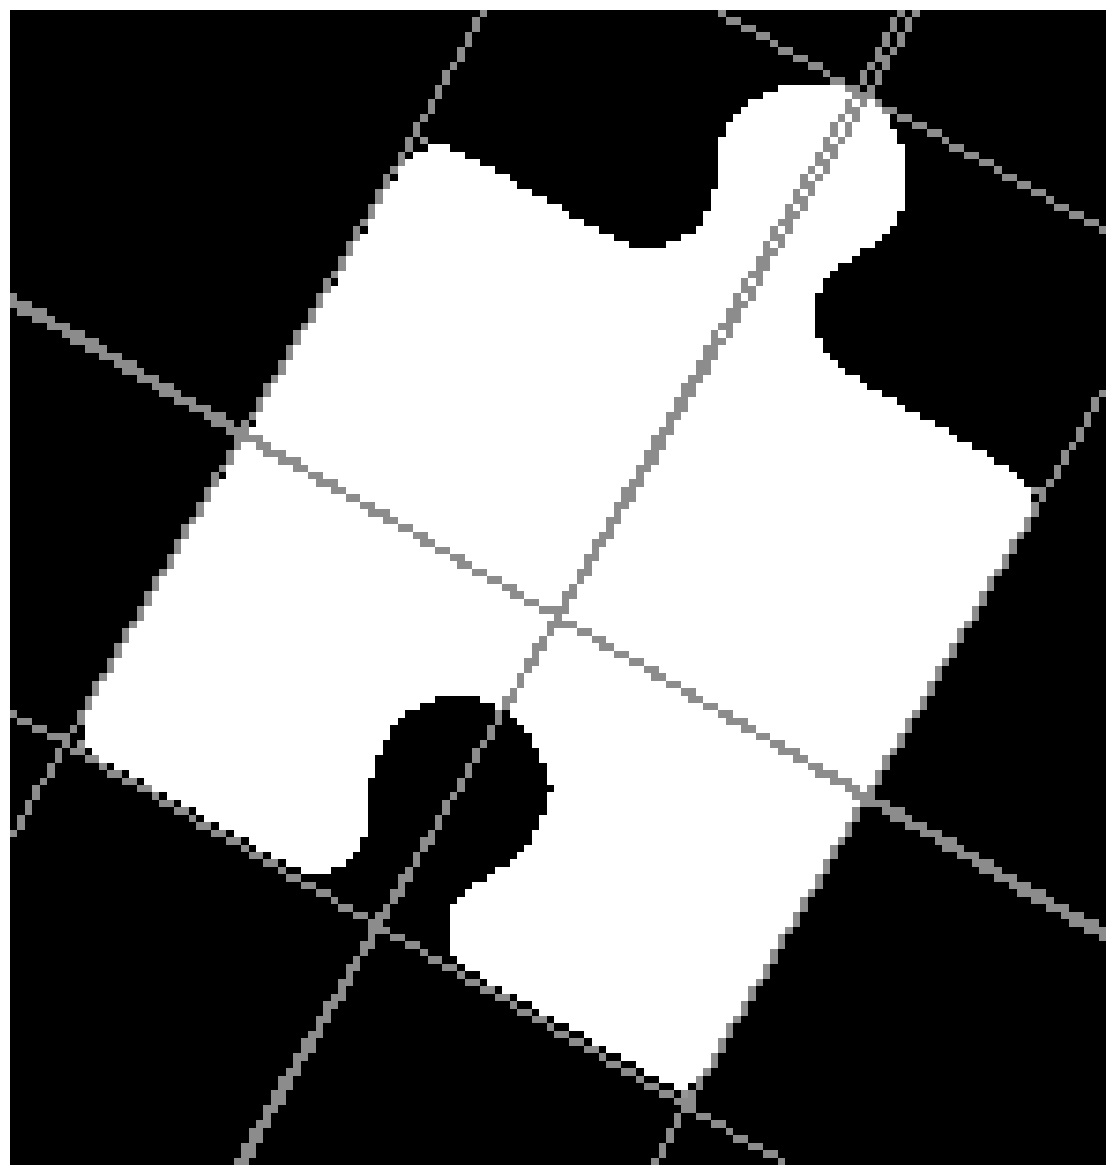

In [55]:
def get_slope_intercept(p1, p2, p3):
    slope = 0
    if(p1[1] != p2[1]):
        slope = (p1[0] - p2[0]) / (p1[1] - p2[1])
    else:
        slope = 999
    intercept = p3[1] - slope*p3[0]
    return [slope, intercept]

for ind, puzzle in enumerate(pieces_corner_coordinates):
    x_avg = sum([j[1] for j in puzzle])/4
    y_avg = sum([j[0] for j in puzzle])/4
    for i in range(4):
        x_mid = (puzzle[i][1] + puzzle[(i+1)%4][1])/2
        y_mid = (puzzle[i][0] + puzzle[(i+1)%4][0])/2
        slope_intercept = get_slope_intercept(puzzle[i], puzzle[(i+1)%4], (x_mid, y_mid))
        inner_line_slope_intercept = [slope_intercept[0], y_avg - slope_intercept[0]*x_avg]
        
        heig, leng = pieces_corner_drawn[ind].shape

        for x in range(leng):
            y = int(slope_intercept[0] * x + slope_intercept[1])
            while 0 <= y < heig:
                if pieces_corner_drawn[ind][y][x] == 255:
                    if(slope_intercept[1] > inner_line_slope_intercept[1]):
                        slope_intercept[1] += 1
                    else:
                        slope_intercept[1] -= 1
                else: break
                y = int(slope_intercept[0] * x + slope_intercept[1])

        if(slope_intercept[0] != 0):
            for y in range(heig):
                x = int(((y-slope_intercept[1]) / slope_intercept[0]))
                while 0 <= x < leng:
                    if pieces_corner_drawn[ind][y][x] == 255:
                        if(slope_intercept[1] > inner_line_slope_intercept[1]):
                            slope_intercept[1] += 1
                        else:
                            slope_intercept[1] -= 1
                    else: break
                    x = int(((y-slope_intercept[1]) / slope_intercept[0]))

        orthogonal_slope = -1/slope_intercept[0] if slope_intercept[0] != 0 else 999
        
        top_left_orthogonal_intercept = puzzle[i][0] - orthogonal_slope*puzzle[i][1]
        top_left_x = (top_left_orthogonal_intercept - slope_intercept[1])/(slope_intercept[0]-orthogonal_slope)
        top_left_y = orthogonal_slope * top_left_x + top_left_orthogonal_intercept
        bottom_left_x = (top_left_orthogonal_intercept - inner_line_slope_intercept[1])/(inner_line_slope_intercept[0]-orthogonal_slope)
        bottom_left_y = orthogonal_slope * bottom_left_x + top_left_orthogonal_intercept 

        top_right_orthogonal_intercept = puzzle[(i+1)%4][0] - orthogonal_slope*puzzle[(i+1)%4][1]
        top_right_x = (top_right_orthogonal_intercept - slope_intercept[1])/(slope_intercept[0]-orthogonal_slope)
        top_right_y = orthogonal_slope * top_right_x + top_right_orthogonal_intercept 
        bottom_right_x = (top_right_orthogonal_intercept - inner_line_slope_intercept[1])/(inner_line_slope_intercept[0]-orthogonal_slope)
        bottom_right_y = orthogonal_slope * bottom_right_x + top_right_orthogonal_intercept 

        square = [(top_right_x, top_right_y), (bottom_right_x, bottom_right_y), (bottom_left_x, bottom_left_y), (top_left_x, top_left_y)]
        square = [(int(x), int(y)) for x, y in square]

        print(square)
        def draw_line(image, slope, intercept, color=140, thickness=1):
            # Get image dimensions
            length, height= image.shape
            x1 = 0
            y1 = int(slope*x1 + intercept)
            x2 = int(height)
            y2 = int(slope*x2 + intercept)
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
        draw_line(pieces_corner_drawn[ind], slope_intercept[0], slope_intercept[1])
        draw_line(pieces_corner_drawn[ind], inner_line_slope_intercept[0], inner_line_slope_intercept[1])

    show_gray(pieces_corner_drawn[ind], "")
                